In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Ignore future warnings from pandas
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*", category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
fname = '/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv'

# 0. Introduction

Objectives:

1. To determine what grade and/or interest rate to give a person to prevent default.
2. To determine that given a loan and/or interest rate will the person default on the loan.
3. To determine how likely a person is to default on the loan.


# 1. First Look at Data

## 1.1. Display First Few Rows

In [2]:
df = pd.read_csv(fname)
print(df.shape)
df.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 1.2. Check Data Types

In [3]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

## 1.3. Check for Missings

In [4]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## 1.4. Consequences of Dropping Missing Rows/Columns

In [5]:
num_points = df.shape[0]*df.shape[1]
emp_length_points = df.shape[1]*895
interest_rate_points = df.shape[1]*3116

print("Lost data due to dropping rows:")
print(f"person_emp_length has {emp_length_points} data points and constitutes {emp_length_points*100/num_points:.2f}% of data.")
print(f"loan_int_rate has {interest_rate_points} data points and constitutes {interest_rate_points*100/num_points:.2f}% of data.")
print(f"Total percentage of data lost from dropping rows: {(emp_length_points+interest_rate_points)*100/num_points:.2f}% of data")
print('')
print(f"Lost data due to dropping columns: {2*df.shape[0]} which constitutes {2*df.shape[0]*100/num_points:.2f}% of data")

Lost data due to dropping rows:
person_emp_length has 10740 data points and constitutes 2.75% of data.
loan_int_rate has 37392 data points and constitutes 9.56% of data.
Total percentage of data lost from dropping rows: 12.31% of data

Lost data due to dropping columns: 65162 which constitutes 16.67% of data


## 1.5. Check for Infinities

In [6]:
non_numeric_feats = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file',
]

np.isinf(df[[col for col in df.columns if col not in non_numeric_feats]].to_numpy()).any()

False

# 2. Check for Outliers

## 2.1. Visualize Data to Look for Outliers

In [7]:
print(f"Home Ownership Values: {df['person_home_ownership'].unique()}")
print(f"Loan Intent Values: {df['loan_intent'].unique()}")
print(f"Loan Grade: {df['loan_grade'].unique()}")
print(f"Credit Default: {df['cb_person_default_on_file'].unique()}")

Home Ownership Values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Loan Intent Values: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Loan Grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
Credit Default: ['Y' 'N']


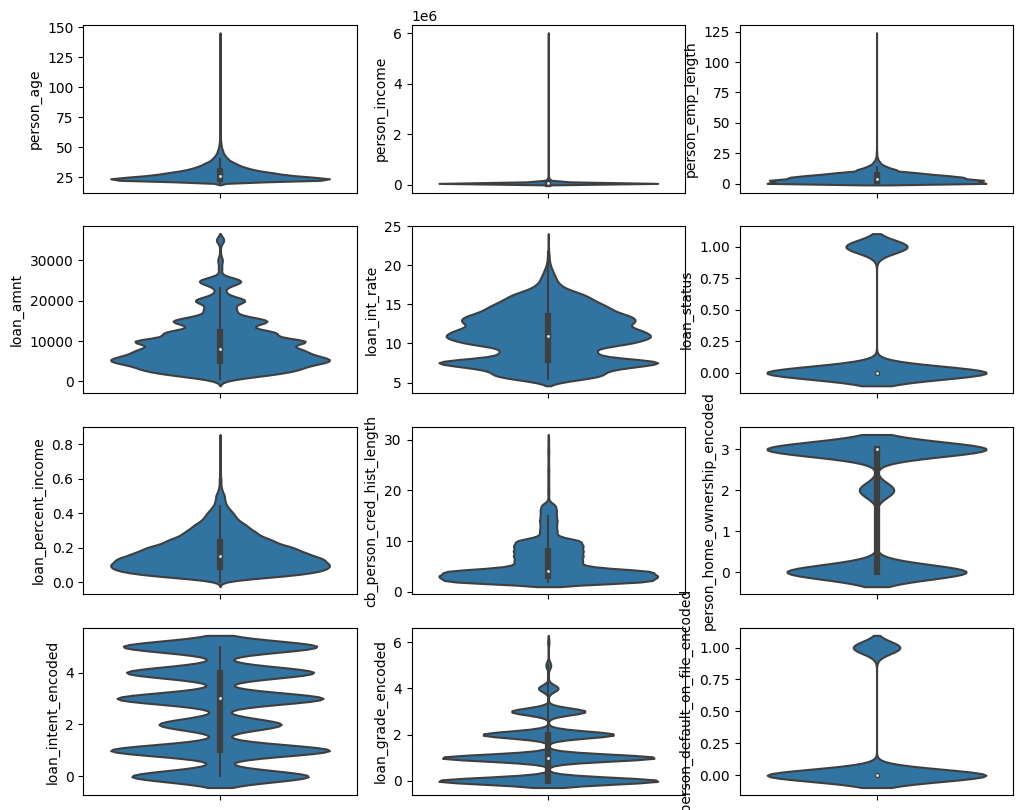

In [8]:
#Load packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

#Load data
df = pd.read_csv(fname)

#Prep data for plotting
non_numeric_feats = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file',
]

#Encode non-numeric columns
encoded_feats = [feat+'_encoded' for feat in non_numeric_feats]
encoder = OrdinalEncoder()
df_ = df.copy()
df_[encoded_feats] = encoder.fit_transform(df_[non_numeric_feats])
df_.drop(non_numeric_feats,axis=1,inplace=True)

#Plot distributions
fig,axs = plt.subplots(4,3,figsize=(12,10))

for ax,feat in zip(axs.flatten(),df_.columns):
    sns.violinplot(data=df_,y=feat,ax=ax)

Some interesting things occur in the data. I see a person who has been employed for approximately 125 years, I see someone is is approximately 150 years old. I will need to go through those features and deal with that data. Let's look a little deeper into these features, by extracting and plotting the values that are greater than 2 standard deviations from the mean.

In [9]:
#Sort features high -> low
outlier_feats = non_numeric_feats + ['loan_status',]
for col in df.columns:
    if col not in outlier_feats:
        print(f"For column {col}")
        print(df[col].sort_values(ascending=False))
        print('')

For column person_age
81       144
32297    144
183      144
747      123
575      123
        ... 
7327      20
16339     20
9926      20
12943     20
1313      20
Name: person_age, Length: 32581, dtype: int64

For column person_income
32297    6000000
30049    2039784
32546    1900000
32497    1782000
31924    1440000
          ...   
15961       4800
15963       4200
27896       4200
15964       4080
31930       4000
Name: person_income, Length: 32581, dtype: int64

For column person_emp_length
0        123.0
210      123.0
32355     41.0
32515     38.0
32428     34.0
         ...  
32285      NaN
32328      NaN
32360      NaN
32453      NaN
32471      NaN
Name: person_emp_length, Length: 32581, dtype: float64

For column loan_amnt
0        35000
17838    35000
17850    35000
15296    35000
140      35000
         ...  
871        500
15951      500
1355       500
8607       500
18502      500
Name: loan_amnt, Length: 32581, dtype: int64

For column loan_int_rate
29277    23.22
2785

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


By sorting the values and printing them, I was able to verify that there are indeed some errors in age and employment length. Since there doesn't appear to be any overlap between age and work history length, I believe these are due to a data entry error.

There are some concerning numbers around the loan_percent of income, but I don't know off hand what the loan_percent_of_income feature is and the data provided does not specify how it is calculated. It could be the percentage of monthly income (most likely) or the percentage of annual income, or a mixture of both. Either way, having a loan that is 86% (top outlier) of your monthly income is unlikely because a lendor wouldn't sign off on that, but I don't know of any lendors who use percentage of yearly income as a metric for lending. The most reasonable course of action is to use values from other data points and try to calculate the metric. My guess is that 86% was supposed to be 8.6%.

## 2.2 Outliers in loan_percent_income

In [10]:
#Load data
df = pd.read_csv(fname)

#Extract relevent data
features = ['person_income','loan_amnt','loan_percent_income']
df_ = df[features].copy()

#Calculate percentage of income:
df_['income_ratio_monthly'] = df_['person_income']/(df_['loan_amnt']*12)
df_['income_ratio_annual'] = df_['loan_amnt']/df_['person_income']

df_[['income_ratio_monthly','income_ratio_annual','loan_percent_income']]



,income_ratio_monthly,income_ratio_annual,loan_percent_income
0,0.140476,0.593220,0.59
1,0.800000,0.104167,0.10
2,0.145455,0.572917,0.57
3,0.155952,0.534351,0.53
4,0.129524,0.643382,0.55
...,...,...,...
32576,0.761494,0.109434,0.11
32577,0.567376,0.146875,0.15
32578,0.180952,0.460526,0.46
32579,0.833333,0.100000,0.10


There we have it, the loan_percent_income feature is the ratio loan_amnt/person_income. Still having a loan that is 80% of your annual income is suspect. A mortgage would usually be much larger than your annual income and most other loan types would be much smaller than your annual income. I will dig deeper into this by looking at the income of people who have large loan_percent_income values.

In [11]:
#Extract Data
features = ['person_income','loan_amnt','loan_percent_income']

#Sort by values >= 50% of income
df_[df_['loan_percent_income']>=0.5][features].sort_values(
    'loan_percent_income',
    ascending=False
) 
idxs_1 = df_.index
df_

,person_income,loan_amnt,loan_percent_income,income_ratio_monthly,income_ratio_annual
0,59000,35000,0.59,0.140476,0.593220
1,9600,1000,0.10,0.800000,0.104167
2,9600,5500,0.57,0.145455,0.572917
3,65500,35000,0.53,0.155952,0.534351
4,54400,35000,0.55,0.129524,0.643382
...,...,...,...,...,...
32576,53000,5800,0.11,0.761494,0.109434
32577,120000,17625,0.15,0.567376,0.146875
32578,76000,35000,0.46,0.180952,0.460526
32579,150000,15000,0.10,0.833333,0.100000


That's strange, a person with an income of 20,000/year is given a loan for 16,600. I don't think that's correct. If I had to guess it's more likely that the 20,000 should be a 200,000, which would put the loan at 8.6% of the person's income. These values aren't good and I can't be sure that the value is a missing 0 in the income or not. If I had to move forward with the data set as-is, I would likely drop the percentage of income feature entirely because it will cause data leakage. If I didn't have to move forward on this, I would still drop the feature but I would want to verify that the incomes are correct with the data owner.

## 2.3 Checking person_income Feature

In [12]:
#Load data
df = pd.read_csv(fname)

#Extract features
features = ['person_income','loan_amnt','loan_percent_income']
df_ = df[features].copy()

#Calculate income from loan amount and percentages
df_['person_income_calculated'] = df_[features[1]]/df_[features[2]]
df_['income_mask'] = (
    (df_['person_income_calculated'] >= 0.85*df['person_income']) &
    (df_['person_income_calculated'] <= 1.15*df_['person_income'])
)
df_['person_income_calculated'] = df_['person_income_calculated'].map(lambda x:x if abs(x) != np.inf else np.nan)
df_ = df_[df_['income_mask']==False][['person_income','person_income_calculated']]
idxs_2 = df_.index
df_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,person_income,person_income_calculated
4,54400,6.363636e+04
17,92111,1.093750e+05
40,62050,7.317073e+04
48,66300,7.894737e+04
124,225000,3.000000e+05
...,...,...
32497,1782000,1.202500e+06
32542,200000,3.000000e+05
32544,780000,4.500000e+05
32546,1900000,NaN


The listed values above have a zero percent of income value if they are NaN. If they are not NaN, then there is an issue with the input income amount or with the loan amount. I would reach out to the data owner to verify these loan amounts and income values.

## 2.4 Check person_age and person_emp_length Features

In [13]:
#Load data
df = pd.read_csv(fname)

#Extract features
features = ['person_age','person_emp_length']
df_ = df[features].copy()

#Check feasability of values
df_['difference_age_emp'] = df_['person_age'] - df_['person_emp_length']
df_['difference_age_emp'] = df_['difference_age_emp'].apply(lambda x:True if x > 10 else False)

df_ = df_[(df_['difference_age_emp']==False)&(df_['person_emp_length'].isna()==False)][['person_age','person_emp_length']]

idxs_1 = df_.index

By subracting age - employment length I should get a number that is either positive or negative. If it is negative, then the data is saying a person has been employed longer than they've been alive. I set the threshold to 10, because most people under 10 years old do not have verifiable employment. I also filtered out NaN values in the person_emp_length feature. Luckily, the result I got was just the two person_emp_length outliers.

## 2.5 Gather All Data with Issues

In [14]:
#Get indices of NaN values
idxs_3 = df[df['person_emp_length']==np.nan].index
idxs_4 = df[df['loan_int_rate']==np.nan].index

#Get values with entry errors (income or loan rate is incorrect, but not NaN)
idxs_entry_error = list(idxs_1)+list(idxs_2)
idxs_entry_error = list(set(idxs_entry_error))
entry_error_df = df.iloc[idxs_entry_error,:]


#Get values with NaNs
idxs_nan_error = list(idxs_3)+list(idxs_4)
idxs_nan_error = list(set(idxs_nan_error))
nan_error_df = df.iloc[idxs_nan_error,:]

The data points in two dataframes above (entry_error_df and nan_error_df) need attention from the data owner. I would export the data as a csv file and write an email to the data owner asking for additional information or corrections.

## 2.6  Assessing Data Errors and NaNs

Since there are missing values in the percent of yearly income column and potentially errors in the income and loan amount columns, I cannot calculate the missing values with any certainty. Instead, I will look at what will happen if I drop these values and continue.

First, I plan to drop the percent of income column because it will cause data leakage and overfitting. Second I will look at the amount of data lost if I drop rows and columns containing NaN values and outliers. I don't think imputation is appropriate here, but it is still an option. From there I will make a decision if I can produce a cleaned data set, ready for analysis.

In [15]:
#Load data
df = pd.read_csv(fname)
df.drop('loan_percent_income',axis=1,inplace=True)

#Calculate total number of data points
n_rows, n_cols = df.shape
num_data_points = n_rows*n_cols


#Calculate percent of data lost if dropping rows and cols due to nans
nan_rows, nan_cols = nan_error_df.shape
pct_nan_rows = nan_cols*nan_rows*100/num_data_points
pct_nan_cols = 200*n_rows/num_data_points #2 columns with nans

#Calculate percent of data lost if dropping rows and cols due to errors
entry_rows, entry_cols = entry_error_df.shape
pct_entry_rows = entry_rows*entry_cols*100/num_data_points
pct_entry_cols = entry_cols*n_rows*100/num_data_points

#print results
print(f"Dropping rows will cause a loss of: {pct_nan_rows+pct_entry_rows}% of data")
print(f"Dropping columns will cause a maximum loss of: {400*n_rows/num_data_points}% of data")


Dropping rows will cause a loss of: 2.3739435421090374% of data
Dropping columns will cause a maximum loss of: 36.36363636363637% of data


It looks like it is safer to just drop the rows that I am having issues with.

## 2.7 Produce a Cleaned Data Set

In [16]:
#Load data and drop calculated columns
df = pd.read_csv(fname)
df.drop('loan_percent_income',axis=1,inplace=True)
before_rows,before_cols = df.shape
df.drop(idxs_entry_error,inplace=True)
df.drop(idxs_nan_error,inplace=True)
after_rows,after_cols = df.shape

print(f"Dataframe lost {100-100*after_rows*after_cols/(before_rows*before_cols):.2f}% of data from dropping selected columns and rows.")

Dataframe lost 2.18% of data from dropping selected columns and rows.


# 3. Visualize Data

## 3.1. Define Functions

In [17]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

def feature_encoder(
    data,
    oh_encode_list=None,
    ord_encode_list=None,
    binary_encode_list=None,
    row_drop_list=None,
    col_drop_list=None,
    drop_nan_rows=True,
    drop_feats=True,
    return_origin=False
):

    #Make redundant copy of data for redundancy purposes to ensure redundant redundancy
    df = data.copy()

    #Encode binary features
    if binary_encode_list:
        for feat in binary_encode_list:
            df[feat+'_enc'] = df[feat].apply(lambda x:1 if x == 'Y' else 0).astype(int)


    #Encode ordinal feats
    if ord_encode_list:
        ord_encoder = OrdinalEncoder()
        df[[feat+'_enc' for feat in ord_encode_list]] = ord_encoder.fit_transform(df[ord_encode_list])

    #Encode one hot feats
    if oh_encode_list:
        oh_encoder = OneHotEncoder()
        oh_encoded_data = oh_encoder.fit_transform(df[oh_encode_list])
        cols = oh_encoder.get_feature_names_out()
        encoded_df = pd.DataFrame(oh_encoded_data.toarray(),columns=cols, index=df.index)
        df = pd.concat((df,encoded_df),axis=1)

    ##Drop pre-encoded feats
    if drop_feats == True:
        
        #Find and drop NaN rows
        if drop_nan_rows == True:
            nan_feats = df.columns[df.isna().any()].tolist()
            drop_nan_idxs = []
            for feat in nan_feats:
                drop_nan_idxs = drop_nan_idxs + list(df[pd.isna(df[feat])].index)
            df.drop(drop_nan_idxs,inplace=True) #Nan values

        #Drop encoded features
        if drop_feats == True:
            if ord_encode_list:
                df.drop(ord_encode_list, axis=1, inplace=True) #Ordinal feats
            if oh_encode_list:
                df.drop(oh_encode_list, axis=1, inplace=True) #One hot feats
            if binary_encode_list:
                df.drop(binary_encode_list, axis=1, inplace=True) #Binary feats

        #Drop user defined features (columns)
        if col_drop_list:
            df.drop(col_drop_list, axis=1, inplace=True)

        #Drop user defined rows
        if row_drop_list:
            df.drop(row_drop_list, inplace=True) #User defined rows

    #Return results
    if return_origin == False:
        return df
    elif return_origin == True:
        return df, data

## 3.2. Correlation Heatmap (Features NOT Encoded)

<Axes: >

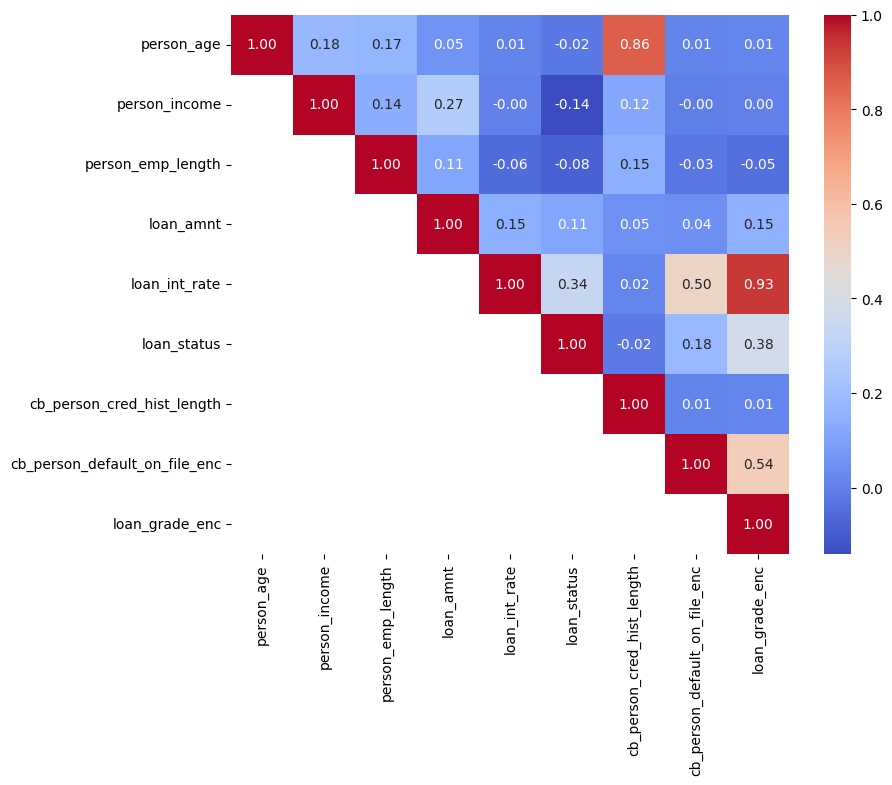

In [18]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
data = pd.read_csv(fname)

#Define drop and encode lists for func
col_drop_list = ['loan_percent_income']
binary_encode_list = ['cb_person_default_on_file']
ord_encode_list = ['loan_grade']

#Call function get cleaned dataset
df = feature_encoder(data=data,ord_encode_list=ord_encode_list,binary_encode_list=binary_encode_list,col_drop_list=col_drop_list)

#Get correlation matrix and mask
corr_mat = df.corr(numeric_only=True)
mask = np.tril(np.ones(corr_mat.shape,dtype='bool'),k=-1)

#Plot
plt.figure(figsize=(9,7))
sns.heatmap(corr_mat, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')


## 3.3. Correlation Matrix Heatmap (Features ARE Encoded)

<Axes: >

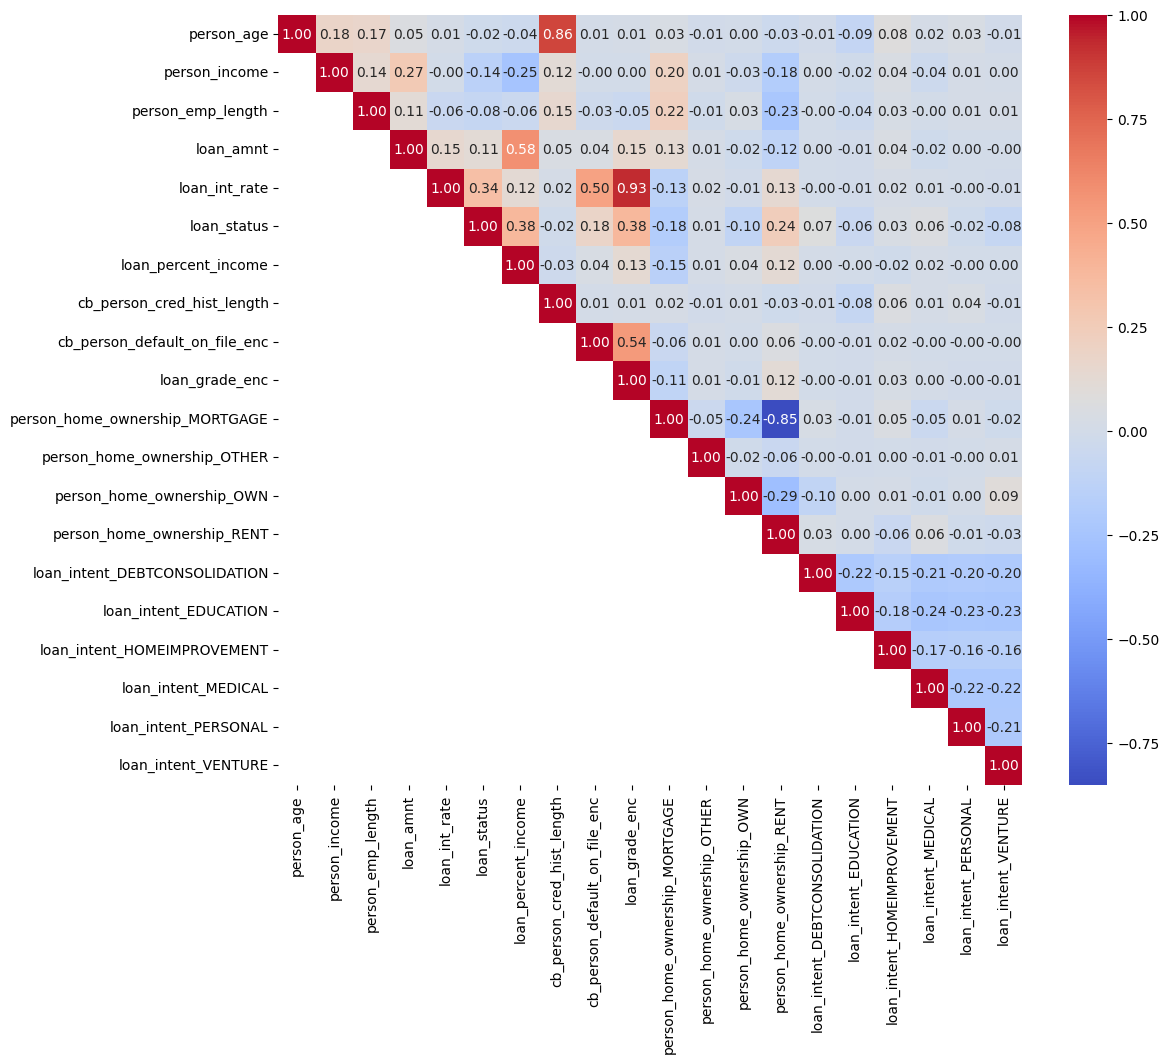

In [19]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

#Load data
data = pd.read_csv(fname)

#Define feature lists for encoding
drop_list = ['loan_percent_income']
oh_feat_list = ['person_home_ownership','loan_intent']
ord_feat_list = ['loan_grade']
binary_feat_list = ['cb_person_default_on_file']

#Call encoder
df = feature_encoder(data=data, oh_encode_list=oh_feat_list, ord_encode_list = ord_feat_list, binary_encode_list = binary_feat_list)

#Get correlation matrix and mask
corr_mat = df.corr(numeric_only=True)
mask = np.tril(np.ones(corr_mat.shape,dtype='bool'),k=-1)

#Plot
plt.figure(figsize=(12,10))
sns.heatmap(corr_mat, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')




## 3.5 Check for Data Leakage

The correlation matrix tells me that there is likely some data leakage in the features.

1. person_age and cb_person_cred_hist_length are highly correlated.
2. loan_int_rate, loan_grade, cb_person_default_on_file are highly correlated

I have two hypotheses that are (1) person_age and cb_person_cred_hist_length are the same feature, but scalled differently and can be used interchangeably. Also, (2) the loan_grade feature encodes the loan_int_rate and cb_person_default_on_file data.

To test these hypothesis I will train a simple support vector classifier (SVC) model, then exchange features and see if there is any improvement. I chose SVC because the target is a binary feature, 'loan_status', that is either 1 or 0 and because I have labeled data but less than 100k data points. I think SVC will perform well here.

They hypotheses are:

$H_0: $ The models perform equally well with or without the feature.

$H_1: $There is a statistically significant difference between model performance.

I will split the data into 10 folds, encode the data for each fold, exchange the features, then perform a t-test to check for statistically significant performance sing the mean absolute error.


In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

def feature_test(X,y,train_idxs,test_idxs,base_feats,suspect_feats,stacked=False,verbose=False,model_params = {}):

    result = []
    
    for i,feat in enumerate(suspect_feats):
        if stacked == True:
            if i != 0:
                base_feats.append(suspect_feats[i-1])

        A_mae = []
        B_mae = []
        
        for train,test in zip(train_idxs,test_idxs):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
        
            model_A = LinearSVC(max_iter=10000,penalty='l1',dual=False)
            model_B = LinearSVC(max_iter=10000,penalty='l1',dual=False)
        
            model_A.fit(X_train[base_feats+[feat]],y_train)
            model_B.fit(X_train[base_feats],y_train)
        
            A_preds = model_A.predict(X_test[base_feats+[feat]])
            B_preds = model_B.predict(X_test[base_feats])
        
            A_mae.append(mean_absolute_error(y_test, A_preds))
            B_mae.append(mean_absolute_error(y_test, B_preds))
        
        t_test, p_val = ttest_rel(A_mae, B_mae)
        result.append([feat,base_feats,t_test,p_val])

        if verbose == True:
            print(f"P-Value: {p_val}")
            if p_val < 0.05:
                print(f"Reject the null: models are statistically different.")
            else:
                print(f"Do not reject null: models are statistically similar.")
    return result



data = pd.read_csv(fname)

#Define feature lists for encoding
drop_list = ['loan_percent_income']
oh_feat_list = ['person_home_ownership','loan_intent']
ord_feat_list = ['loan_grade']
binary_feat_list = ['cb_person_default_on_file']

#Call custom encoder
df = feature_encoder(
    data=data, 
    oh_encode_list=oh_feat_list, 
    ord_encode_list = ord_feat_list, 
    binary_encode_list = binary_feat_list,
)

#Seperate features and target
X = df.copy()
y = X.pop('loan_status')

#Scale features to prevent convergence issues
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

#Define features to test
suspect_feats_1 = ['person_age','cb_person_cred_hist_length',]
suspect_feats_2 = ['loan_int_rate','loan_grade_enc','cb_person_default_on_file_enc']
base_feats_1 = [feat for feat in X.columns if feat not in suspect_feats_1]
base_feats_2 = [feat for feat in X.columns if feat not in suspect_feats_2]

#Get indices of folds
train_idxs = []
test_idxs = []
kfolds = StratifiedKFold(n_splits=10)
for train, test in kfolds.split(X,y):
    train_idxs.append(train)
    test_idxs.append(test)


In [21]:
results_1 = feature_test(
    X=X_scaled,
    y=y,
    train_idxs=train_idxs,
    suspect_feats=suspect_feats_1,
    base_feats=base_feats_1,
    test_idxs=test_idxs,
    verbose=True,
    stacked=True,
)
results_2 = feature_test(
    X=X_scaled,
    y=y,
    train_idxs=train_idxs,
    suspect_feats=suspect_feats_2,
    base_feats=base_feats_2,
    test_idxs=test_idxs,
    verbose=True,
    stacked=True,
)



P-Value: 0.2549267163511591
Do not reject null: models are statistically similar.
P-Value: 0.6165704771402598
Do not reject null: models are statistically similar.
P-Value: 0.000485689888623834
Reject the null: models are statistically different.
P-Value: 0.0007874744099545905
Reject the null: models are statistically different.
P-Value: 0.11986265230555958
Do not reject null: models are statistically similar.


From the results of the hypothesis testing It looks like the loan_int_rate and loan_grade are sharing approximately the same information and one of them should be dropped. I would most likely build a model for each and see which performs better.

## 3.6 Check for Class Imbalances

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


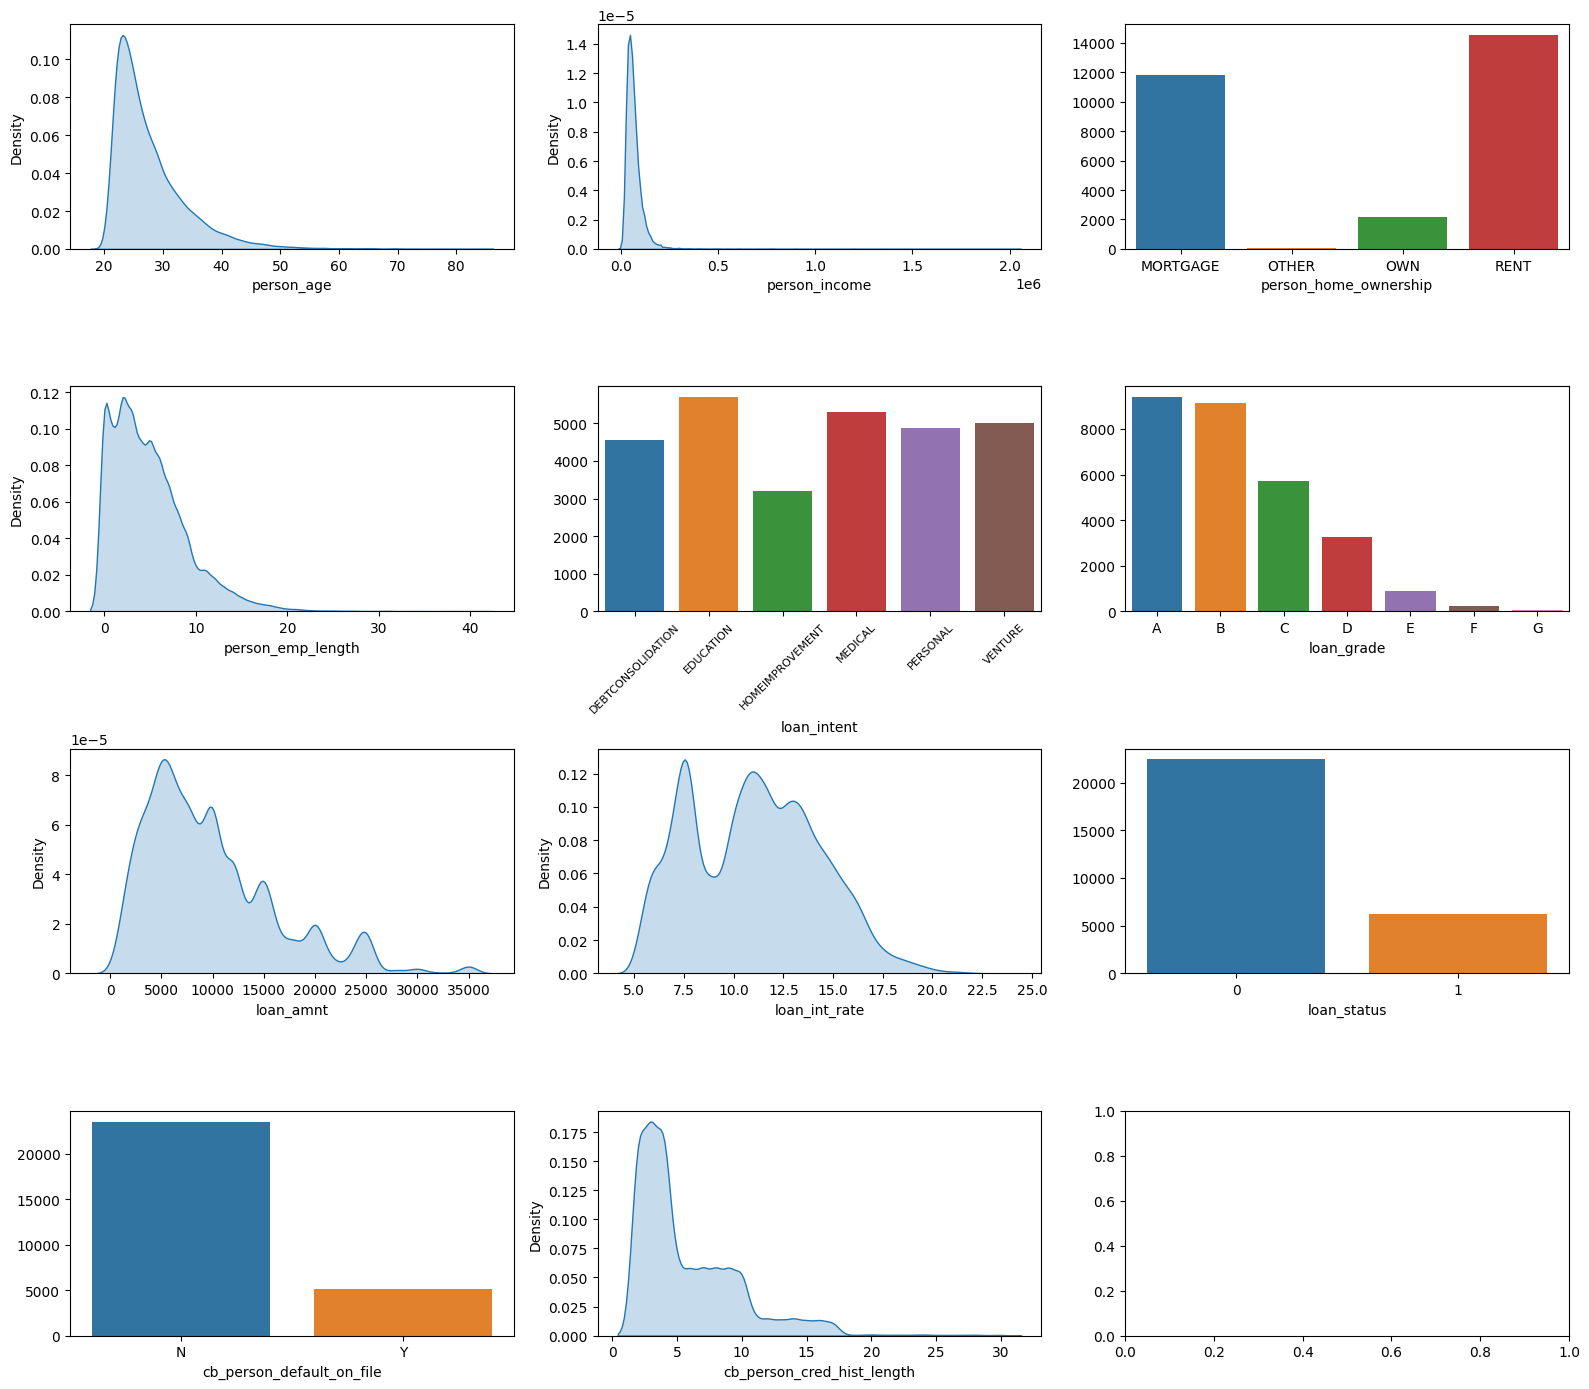

In [22]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

#Load data
data = pd.read_csv(fname)

data['mask'] = ((data['person_age']>=100)|(data['cb_person_cred_hist_length']>=100)|(data['person_emp_length']>100))
data.drop(data[data['mask']==True].index,inplace=True)
df = feature_encoder(data,col_drop_list=['loan_percent_income'],)

#Plot
fig, axs = plt.subplots(4,3,figsize=(16,14))

bar_feats = ['loan_status','cb_person_default_on_file','loan_grade','loan_intent','person_home_ownership']
kde_feats = ['person_age','person_income','person_emp_length','loan_percent_income','cb_person_cred_hist_length','loan_amnt','loan_int_rate']

for ax,feat in zip(axs.flatten(),df.columns):
    if feat in bar_feats:
        counts = df[feat].value_counts().sort_index()
        sns.barplot(x=counts.index, y=counts.values,ax=ax,)
    elif feat in kde_feats:
        sns.kdeplot(data=df, x=feat, ax=ax,fill=True)

    if feat == 'loan_intent':
        ax.tick_params(axis='x',rotation=45, labelsize=8)

plt.tight_layout()


It looks like loan_status and cb_person_default_on_file are very similar in their distribution, but the correlation doesn't seem to agree. When I did the correlation heatmaps I only used pearson to capture linear relationships, but I did not use spearman or any other methods to capture non-linear relationships.

I also see an imbalance in the target and highly skewed results for cb_person_cred_hist_length, person_emp_length, and person_age. 

### Actionable Insights:
1. Log or square root transform the skewed data. (person_age, person_income, and person_emp_length)
2. Check for non-linear interaction between features.
3. Possibly impute to balance the loan status feature.
4. Bin person_age, loan_int_rate, and loan_amnt featuress.

## 3.7 Mathematically Transform Features

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


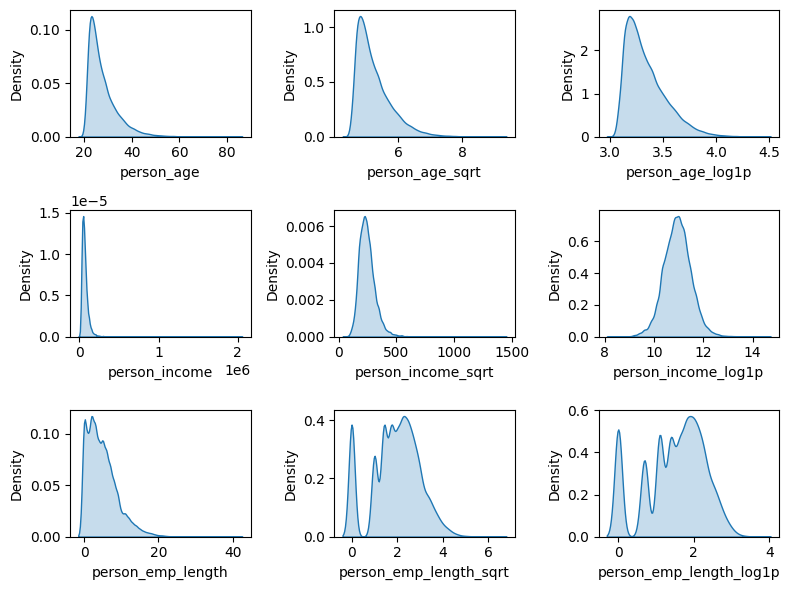

In [23]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
data = pd.read_csv(fname)

#Transform features
data['mask'] = ((data['person_age']>=100) | (data['cb_person_cred_hist_length']>=100)|(data['person_emp_length']>100))
data.drop(data[data['mask']==True].index,inplace=True)
df = feature_encoder(data,col_drop_list=['loan_percent_income'],)

#Perform mathematical transforms
transform_feats = ['person_age','person_income','person_emp_length',]
sqrt_feats = [feat+'_sqrt' for feat in transform_feats]
log1p_feats = [feat+'_log1p' for feat in transform_feats]
sqrt_df = df[transform_feats].apply(lambda x:np.sqrt(x))
log1p_df = df[transform_feats].apply(lambda x:np.log1p(x))
df_cols = list(df.columns)+sqrt_feats+log1p_feats

df = pd.concat((df,sqrt_df,log1p_df),axis=1,ignore_index=0)
df.columns = df_cols

#Plot data
fig, axs = plt.subplots(3,3,figsize=(8,6))

for i,(transform_feat,sqrt_feat,log1p_feat) in enumerate(zip(transform_feats,sqrt_feats,log1p_feats)):
    sns.kdeplot(data=df,x=transform_feat,ax=axs[i,0],fill=True)
    sns.kdeplot(data=df,x=sqrt_feat,ax=axs[i,1],fill=True)
    sns.kdeplot(data=df, x=log1p_feat,ax=axs[i,2],fill=True)


plt.tight_layout()

I think a log transform works well and helps scale the data better, to make sure this is the case I will train three models and see which one performs better.

### 3.8 Bin Features

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


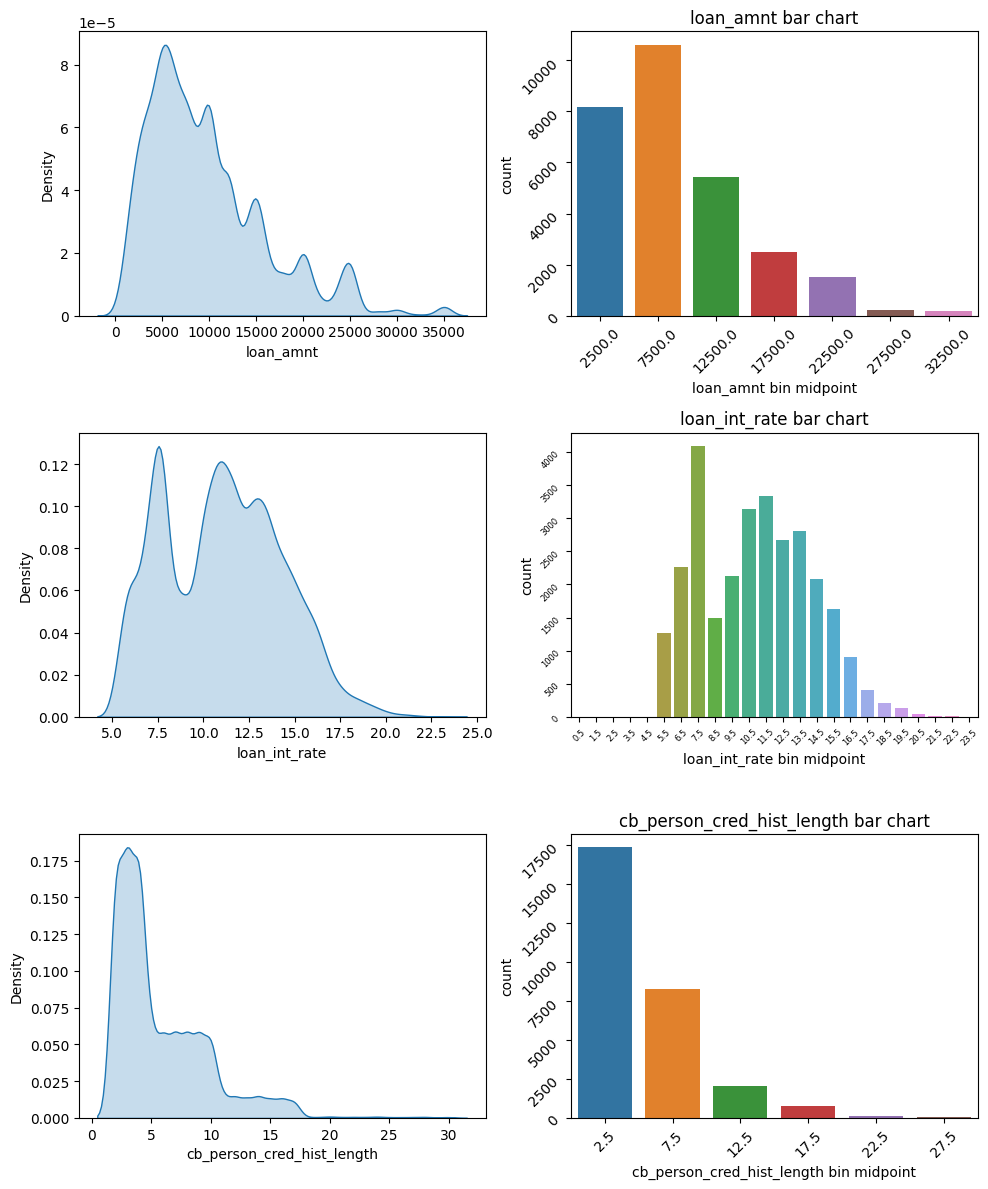

In [24]:
#Import packages
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
data = pd.read_csv(fname)

#Transform features
data['mask'] = ((data['person_age']>=100) | (data['cb_person_cred_hist_length']>=100)|(data['person_emp_length']>100))
data.drop(data[data['mask']==True].index,inplace=True)
df = feature_encoder(data,col_drop_list=['loan_percent_income'],)

#Make variables to bin features
bin_widths = {
    'loan_amnt':[5000,df['loan_amnt'].max()],
    'loan_int_rate':[1,df['loan_int_rate'].max()],
    'cb_person_cred_hist_length':[5,df['cb_person_cred_hist_length'].max()],
}
binned_feat_names = [feat+'_binned' for feat in bin_widths.keys()]

#Initialize storage
feat_counts = {}

#Get feature counts 
for binned_feat,(feat,(bin_width,feat_max)) in zip(binned_feat_names,bin_widths.items()):
    edges = np.arange(0,feat_max+bin_width,bin_width)
    binned_counts = pd.cut(df[feat],bins=edges).value_counts().sort_index()
    binned_counts.index = [idx.mid for idx in list(binned_counts.index)]
    feat_counts[feat] = binned_counts

#Plot
fig, axs = plt.subplots(3,2,figsize=(10,12))

for i, (feat,counts_data) in enumerate(feat_counts.items()):
    #Plot the old kde plot
    sns.kdeplot(data=df,x=feat,ax=axs[i,0],fill=True)

    #Bar plot new binned data
    sns.barplot(x=counts_data.index,y=counts_data,orientation='vertical',ax=axs[i,1])
    axs[i,1].set_title(f"{feat} bar chart")
    axs[i,1].set_xlabel(f"{feat} bin midpoint")
    axs[i,1].tick_params(rotation=45)
    if feat == 'loan_int_rate':
        axs[i,1].tick_params(labelsize=6)
    

plt.tight_layout()

In the previous two sections I did the following:
1. Dropped the feature 'loan_percent_income'
2. Dropped rows featuring NaNs
3. Dropped rows where 'person_age', 'person_cred_hist_length', or 'person_emp_length' are too large (>100 years)
4. Performed a log transform on 'person_age', 'person_income', and 'person_emp_length'
5. Binned the features 'loan_amnt','loan_int_rate', and 'cb_person_cred_hist_length'.
6. One hot encoding on 'person_home_ownership' and 'loan_intent'
7. Ordinal encoding on 'loan_grade'.
8. Binary encoding on 
9. Standard Scaler on features that weren't encoded.

# 4. Exploratory Data Analysis

## 4.1. Produce Data Set (Define Data Parsing Class)

In [59]:
#Import packages
import operator

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from functools import reduce

class FeatureTransform():
    def __init__(self,data,params):
        self.data = data
        self.df = data.copy()
        self.params = params

        if self.params['func_calls']['drop_rows_over_threshold'] == True:
            self.drop_rows_over_threshold()

        if self.params['func_calls']['drop_columns'] == True:
            self.drop_columns()

        if self.params['func_calls']['drop_nan_rows'] == True:
            self.drop_nan_rows()

        if self.params['func_calls']['numeric_transform'] == True:
            self.numeric_transform()

        if self.params['func_calls']['feature_encoder'] == True:
            self.feature_encoder()

        if self.params['func_calls']['feature_scaler'] == True:
            self.feature_scaler()

        if self.params['func_calls']['inverse_feature_encoder'] == True:
            self.inverse_feature_encoder()
            

    def drop_rows_over_threshold(self):
        '''
        Looks at each feature in a user defined list, checks for entries over the
        threshold, drops rows with values in each column over the threshold.
        '''
        df = self.df.copy()
        #Make Mask
        mask_list = []
        for feat,threshold in self.params['drop_rows_over_threshold']['thresholds'].items():
            partial_mask = df[feat] > threshold
            mask_list.append(partial_mask)
        df['mask'] = reduce(operator.or_,mask_list)

        #Drop feats
        self.df.drop(df[df['mask']==True].index,inplace=True)
        if self.params['drop_rows_over_threshold']['drop_mask'] == True:
            df.drop('mask',axis=1,inplace=True)

        self.df = df

    def drop_columns(self):
        '''
        Drops columns/features from a list of features defined by user.
        '''
        df = self.df.copy()
        
        drop_col_list = self.params['drop_cols']['col_drop_list']
        df.drop(drop_col_list,axis=1,inplace=True)

        self.df = df

    def drop_nan_rows(self):
        '''
        Drops all rows containing a nan value
        '''

        df = self.df.copy()
        row_nan_mask = pd.isna(df).any(axis=1)
        df = self.df[~row_nan_mask]
        self.df = df

    def numeric_transform(self):

        df = self.df.copy()
        #Extract variables from exam
        log_transform_bool = self.params['numeric_transform']['log_transform']
        log_transform_list = self.params['numeric_transform']['log_transform_feats']
        sqrt_transform_bool = self.params['numeric_transform']['sqrt_transform']
        sqrt_transform_list = self.params['numeric_transform']['sqrt_transform_feats']

        #Perform log transform
        if log_transform_bool == True:
            self.log_transformed_names = [feat+'_log' for feat in log_transform_list]
            for old_feat,new_feat in zip(log_transform_list,self.log_transformed_names):
                df[new_feat] = np.log1p(self.df[old_feat])

        #Perform square root transform
        if sqrt_transform_bool == True:
            self.sqrt_transformed_names = [feat+'_sqrt' for feat in sqrt_transform_list]
            for old_feat,new_feat in zip(sqrt_transform_list,self.sqrt_transformed_names):
                df[new_feat] = np.sqrt(self.df[old_feat])

        #Drop features if drop_feats is True
        if self.params['numeric_transform']['drop_feats'] == True:
            if log_transform_bool == True:
                df.drop(log_transform_list,axis=1,inplace=True)
            elif sqrt_transform_bool == True:
                df.drop(sqrt_transform_list,axis=1,inplace=True)

        self.df = df

    def bin_features(self):
        '''
        Bins features from a dictionary by bin width and appends new features to the 
        dataframe. Can drop features if requested. Can also return the bin names and counts
        for use in a bar plot.
        self.df['bin_features']['return_counts'] (bool) = True will return counts for barplot
        self.df['bin_features']['drop_feats'] (bool) = True will drop the old features from
            the dataframe.
        self.df['bin_features']['bin_width'] (dict of dicts):
            key,value -> key = old_feat name, value = list(bin_width, feature_max)
        '''    
        df = self.df.copy()
        #Extract variables from params
        return_counts = self.params['bin_features']['return_counts']
        drop_feats = self.params['bin_feats']['drop_feats']
        bin_width = self.params['bin_features']['bin_widths']

        #Generate new feature names
        binned_feature_names = [feat+'_binned' for feat in bin_width.keys()]

        ##Bin data
        #Initialize storaget
        if return_counts == True:
            feat_counts = {}

        if drop_feats == True:
            feats_to_drop = []

        #Bin each data by category
        for new_feat,(old_feat,(bin_width, bin_max)) in zip(binned_feature_names,bin_width.items()):
            edges = np.arange(0,bin_max+bin_width,bin_width)
            binned_data = pd.cut(df[old_feat],bins=edges)
            df[new_feat] = binned_counts

            #Append to drop list
            if drop_feats == True:
                feats_to_drop.append(feat)

            #Get bin counts for bar plotting
            if return_counts == True:
                binned_counts = binned_data.value_counts().sort_index()
                binned_counts.index = [idx.mid for idx in list(binned_counts.index)]
                feat_counts[new_feat] = binned_counts

        #Append counts to self object
        if return_counts == True:
            self.feat_counts = feat_counts

        #Drop features if requested
        if drop_feats == True:
            df.drop(feats_to_drop,axis=1,inplace=True)

        self.df = df

        
    def feature_encoder(self):
        df = self.df.copy()
        #Extract variables from params
        binary_encode_list = self.params['feature_encoder']['binary_encode_list']
        ord_encode_list = self.params['feature_encoder']['ord_encode_list']
        oh_encode_list = self.params['feature_encoder']['oh_encode_list']
        drop_feats = self.params['feature_encoder']['drop_feats']
        
        
        #Encode binary features
        if binary_encode_list:
            self.binary_transformed_names = [feat+'_enc' for feat in binary_encode_list]
            for old_feat,new_feat in zip(binary_encode_list,self.binary_transformed_names):
                df[new_feat] = df[old_feat].apply(lambda x:1 if x == 'Y' else 0).astype(int)
    
        #Encode ordinal feats
        if ord_encode_list:
            ord_encoder = OrdinalEncoder()
            self.ord_transformed_names = [feat+'_enc' for feat in ord_encode_list]
            df[self.ord_transformed_names] = ord_encoder.fit_transform(df[ord_encode_list])
            self.ord_encoder = ord_encoder
            
        #Encode one hot feats
        if oh_encode_list:
            oh_encoder = OneHotEncoder(drop='first')
            oh_encoded_data = oh_encoder.fit_transform(df[oh_encode_list])
            self.oh_transformed_names = oh_encoder.get_feature_names_out()
            encoded_df = pd.DataFrame(
                oh_encoded_data.toarray(),
                columns=self.oh_transformed_names,
                index=df.index
            )
            df = pd.concat((df,encoded_df),axis=1)
            self.oh_encoder = oh_encoder
    
        ##Drop pre-encoded feats
        if drop_feats == True:
            if ord_encode_list:
                df.drop(ord_encode_list, axis=1, inplace=True) #Ordinal feats
            if oh_encode_list:
                df.drop(oh_encode_list, axis=1, inplace=True) #One hot feats
            if binary_encode_list:
                df.drop(binary_encode_list, axis=1, inplace=True) #Binary feats

        self.df = df
        
    def inverse_feature_encoder(self):

        #Extract variables from params
        oh_encode = self.params['inverse_feature_encoder']['oh_encode']
        ord_encode = self.params['inverse_feature_encoder']['ord_encode']
        binary_encode = self.params['inverse_feature_encoder']['binary_encode']
        sqrt_encode = self.params['inverse_feature_encoder']['sqrt_encode']
        log_encode = self.params['inverse_feature_encoder']['log_encode']

        #Perform inverse one hot encoding
        if oh_encode == True:
            old_oh_feats = self.params['feature_encoder']['oh_encode_list']
            unencoded_oh_feats = [feat+'_unencoded' for feat in old_oh_feats]
            self.df[unencoded_oh_feats] = self.oh_encoder.inverse_transforms(self.df[self.oh_transformed_names])
        
        #Perform inverse ordinal encoding
        if ord_encode == True:
            old_ord_feats = self.params['feature_encoder']['ord_encode_list']
            unencoded_ord_feats = [feat+'_unencoded' for feat in old_ord_feats]
            self.df[unencoded_ord_feats] = self.ord_encoder.fit_transform(self.df[self.ord_transformed_names])

        #Perform inverse binary encoding
        if binary_encode == True:
            old_binary_feats = self.params['feature_encoder']['binary_encode_list']
            unencoded_binary_feats = [feat+'_unencoded' for feat in old_binary_feats]
            self.df[unencoded_binary_feats] = self.df[self.binary_transformed_names].apply(lambda x:'Y' if x == 1 else 'N')

        #Perform inverse log transform
        if log_encode == True:
            old_log_feats = self.params['numeric_transform']['log_transform_feats']
            unencoded_log_feats = [feat+'_unencoded' for feat in old_log_feats]
            self.df[unencoded_log_feats] = np.exp(self.df[self.log_transformed_names]) - 1

        #Perform inverse square root transform
        if sqrt_encode == True:
            old_sqrt_feats = self.params['numeric_transform']['sqrt_transform_feats']
            unencoded_sqrt_feats = [feat+'_unencoded' for feat in old_sqrt_feats]
            self.df[unencoded_sqrt_feats] = np.square(self.df[self.sqrt_transformed_names])

    def feature_scaler(self):
        df = self.df.copy()

        #Make list of features to exclude
        no_scale_feats = [list(self.binary_transformed_names),list(self.oh_transformed_names),list(self.ord_transformed_names)]
        no_scale_feats = [f for feat in no_scale_feats for f in feat]
        no_scale_feats.append(self.params['target'])

        
        #Make list of feats to include
        feats_to_scale = [feat for feat in df.columns if feat not in no_scale_feats]
        

        #Generate new feature names
        self.scaled_transformed_names = [
            feat+'_scaled' 
            for feat 
            in df.columns 
            if feat 
                not in no_scale_feats
        ]

        #Scale included feats
        scaler = StandardScaler()
        df[self.scaled_transformed_names] = scaler.fit_transform(df[feats_to_scale])

        self.df = df
    

## 4.2. Define Data Feature t-Test Function

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

def feature_test(X,y,train_idxs,test_idxs,feature_list_A, feature_list_B,verbose=True):
    '''
    Extracts common features from two lists of features. Compares the model results from models trained with
    features A and common, features B and common, and features A vs features B using a t-test to determine if
    there is a statistically significant difference between the results of the two models.
    '''

    #Define variables
    max_iter=15000
    
    #Initialize storage
    result = {}
    A_mae = []
    B_mae = []
    C_mae = []

    #Get features that are the intersection of list 1 and list 2
    common_feats = list(set(feature_list_A) & set(feature_list_B))
    
    for train,test in zip(train_idxs,test_idxs):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
    
        model_A = LinearSVC(max_iter=max_iter,penalty='l1',dual=False,class_weight='balanced',C=5,)
        model_B = LinearSVC(max_iter=max_iter,penalty='l1',dual=False,class_weight='balanced',C=5,)
        model_C = LinearSVC(max_iter=max_iter,penalty='l1',dual=False,class_weight='balanced',C=5,)
    
        model_A.fit(X_train[feature_list_A],y_train)
        model_B.fit(X_train[feature_list_B],y_train)
        model_C.fit(X_train[common_feats],y_train)
    
        A_preds = model_A.predict(X_test[feature_list_A])
        B_preds = model_B.predict(X_test[feature_list_B])
        C_preds = model_C.predict(X_test[common_feats])
    
        A_mae.append(mean_absolute_error(y_test, A_preds))
        B_mae.append(mean_absolute_error(y_test, B_preds))
        C_mae.append(mean_absolute_error(y_test, C_preds))
    
    t_test_AC, p_val_AC = ttest_rel(A_mae, C_mae)
    t_test_BC, p_val_BC = ttest_rel(B_mae, C_mae)
    t_test_AB, p_val_AB = ttest_rel(A_mae, B_mae)
    
    result['AC'] = {'t_test':t_test_AC,'p_val':p_val_AC,'feats_A':feature_list_A,'feats_C':common_feats,}
    result['BC'] = {'t_test':t_test_BC,'p_val':p_val_BC,'feats_B':feature_list_B,'feats_C':common_feats,}
    result['AB'] = {'t_test':t_test_AB,'p_val':p_val_AB,'feats_A':feature_list_A,'feats_B':feature_list_B,}
    result['errors'] = {'mae_A':A_mae,'mae_B':B_mae,'mae_C':C_mae}

    if verbose == True:
        print(f"P-Value for Feature A and Common Features: {p_val_AC}")
        if p_val_AC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature B and Common Features: {p_val_BC}")
        if p_val_BC < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")

        print(f"P-Value for Feature A and Feature B: {p_val_AB}")
        if p_val_AB < 0.05:
            print(f"Reject the null: models are statistically different.")
        else:
            print(f"Do not reject null: models are statistically similar.")
    return result

## 4.3. Define Parameter File for Data Encoding Class

In [51]:
#Load data
df = pd.read_csv(fname)

#Define parameter file
params = {
    'target':'loan_status',
    'func_calls':{
        'drop_rows_over_threshold':True,
        'drop_columns':True,
        'drop_nan_rows':True,
        'numeric_transform':True,
        'feature_encoder':True,
        'inverse_feature_encoder':False,
        'feature_scaler':True,
    },
    'drop_rows_over_threshold':{'thresholds':{
            'person_age':100,
            'cb_person_cred_hist_length':100,
            'person_emp_length':100,
        },                          
        'drop_mask':True,
    },
    'drop_nan_rows':{
        'drop_rows':True,
    },
    'drop_inf_rows':{
        'drop_rows':True, #Not implimented, only here incase I need it later
    },
    'drop_cols':{
        'col_drop_list':['loan_percent_income']
    },
    'numeric_transform':{
        'log_transform':True,
        'log_transform_feats':['person_age','person_income','person_emp_length'],
        'sqrt_transform':True,
        'sqrt_transform_feats':['person_age','person_income','person_emp_length'],
        'drop_feats':True,
    },
    'bin_features':{
        'bin_widths':{
            'loan_amnt':[5000,df['loan_amnt'].max()],
            'loan_int_rate':[1,df['loan_int_rate'].max()],
            'cb_person_cred_hist_length':[5,df['cb_person_cred_hist_length'].max()],
        },
        'return_counts':False,
        'drop_feats':True,
    },
    'feature_encoder':{
        'oh_encode_list':['person_home_ownership','loan_intent'],
        'ord_encode_list':['loan_grade'],
        'binary_encode_list':['cb_person_default_on_file'],
        'drop_feats':True,
    },
    'inverse_feature_encoder':{
        'oh_encode':True,
        'ord_encode':True,
        'binary_encode':True,
        'log_transform':True,
        'sqrt_transform':True,
    },
}



## 4.4. Feature Selection (Square Root vs Log Scaled Features)

In this subsection I will attempt to see if there is a difference between two features.

In [37]:
#Get encoded features
feature_transform = FeatureTransform(df,params)

#Seperate features and target
X = feature_transform.df.copy()
y = X.pop('loan_status')

#Define features to test
sqrt_feats = [
    'person_age_sqrt_scaled',
    'person_income_sqrt_scaled',
    'person_emp_length_sqrt_scaled',
]

log_feats = [
    'person_age_log_scaled',
    'person_income_log_scaled',
    'person_emp_length_log_scaled',
]

base_feats = [
    'cb_person_default_on_file_enc',
    'loan_grade_enc', 
    #'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    #'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'loan_amnt_scaled',
    'loan_int_rate_scaled',
    'cb_person_cred_hist_length_scaled',
]

#Get indices of folds
train_idxs = []
test_idxs = []
kfolds = StratifiedKFold(n_splits=10)
for train, test in kfolds.split(X,y):
    train_idxs.append(train)
    test_idxs.append(test)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [38]:
feature_test_results = feature_test(
    X=X, y=y,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    feature_list_A = base_feats+log_feats,
    feature_list_B = base_feats+sqrt_feats,
    verbose=True,
)

avg_mae_A = np.mean(feature_test_results['errors']['mae_A'])
avg_mae_B = np.mean(feature_test_results['errors']['mae_B'])
avg_mae_C = np.mean(feature_test_results['errors']['mae_C'])

print('\n\n')
print('MAE averaged over 10 folds using LinearSVC model:')
print(f"Average MAE for Feature A is: {avg_mae_A:.4f}")
print(f"Average MAE for Feature B is: {avg_mae_B:.4f}")
print(f"Average MAE for Feature C is: {avg_mae_C:.4f}")


P-Value for Feature A and Common Features: 1.8186636885883555e-05
Reject the null: models are statistically different.
P-Value for Feature B and Common Features: 8.227167971895064e-05
Reject the null: models are statistically different.
P-Value for Feature A and Feature B: 0.007810144519009088
Reject the null: models are statistically different.



MAE averaged over 10 folds using LinearSVC model:
Average MAE for Feature A is: 0.2227
Average MAE for Feature B is: 0.2310
Average MAE for Feature C is: 0.2799


I encoded, transformed, and scaled the dataset first. Next, I split the dataset up into 10 folds of test and train datasets. I then trained 3 different LinearSVC models with the same data points, made predictions, and calculated the mean absolute error for each fold. When this was done, I compared the results of the 10 folds together (A&B), (A&C), and (B&C) feature sets. Feature set A contained square root transforms, feature set B contained log1p transformed, and feature set C did not contain these features at all. The transformed features were: person_age, person_income, and person_emp_length. Finally, I averaged the mean absolute error across all 10 folds to get three averaged errors.

Based on these results, we see that the mean absolute error for the LinearSVC models with square root and log transforms perform about the same against the model that does not contain these features at all. However, when we compare them together they are statistically different (which doesn't tell us much about their predictive power), but without these features the average mean absolute error was around 0.28. This indicates that the model performs worse without these features so they have some predictive power. I will use the square root transformed features because their average mean absolute error was slightly lower than the log1p transformed features.

### Actionable Insights:
Square root transform the features: person_age, person_income, and person_emp_length

## 4.4 Feature Selection (Highly Correlated - person_age vs person_cred_hist_length)

In [39]:
#Get encoded features
feature_transform = FeatureTransform(df,params)

#Seperate features and target
X = feature_transform.df.copy()
y = X.pop('loan_status')

#Define features to test
person_age = [
    'person_age_sqrt_scaled',
]

cred_hist = [
    'cb_person_cred_hist_length'
]

base_feats = [
    'cb_person_default_on_file_enc',
    'loan_grade_enc', 
    #'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    #'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'loan_amnt_scaled',
    'loan_int_rate_scaled',
    #'cb_person_cred_hist_length_scaled',
    #'person_age_sqrt_scaled',
    'person_income_sqrt_scaled',
    'person_emp_length_sqrt_scaled',
]

#Get indices of folds
train_idxs = []
test_idxs = []
kfolds = StratifiedKFold(n_splits=10)
for train, test in kfolds.split(X,y):
    train_idxs.append(train)
    test_idxs.append(test)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [40]:
feature_test_results = feature_test(
    X=X, y=y,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    feature_list_A = base_feats+person_age,
    feature_list_B = base_feats+cred_hist,
    verbose=True,
)

avg_mae_A = np.mean(feature_test_results['errors']['mae_A'])
avg_mae_B = np.mean(feature_test_results['errors']['mae_B'])
avg_mae_C = np.mean(feature_test_results['errors']['mae_C'])

print('\n\n')
print('MAE averaged over 10 folds using LinearSVC model:')
print(f"Average MAE for Feature A is: {avg_mae_A:.4f}")
print(f"Average MAE for Feature B is: {avg_mae_B:.4f}")
print(f"Average MAE for Feature C is: {avg_mae_C:.4f}")

P-Value for Feature A and Common Features: 0.7911551104569203
Do not reject null: models are statistically similar.
P-Value for Feature B and Common Features: 0.5330621048619129
Do not reject null: models are statistically similar.
P-Value for Feature A and Feature B: 0.5949917960175801
Do not reject null: models are statistically similar.



MAE averaged over 10 folds using LinearSVC model:
Average MAE for Feature A is: 0.2315
Average MAE for Feature B is: 0.2311
Average MAE for Feature C is: 0.2320


The p-values show that feature A error varies from the common features more than feature B's error does. Since the average mae is approximately the same for AB, AC, and BC, I think that the best feature to use is feature B because it's error is more similar to the common features error without sacrificing accuracy. But I feat that this might lead to overfitting.

### Actionable Insight:
1. Drop the 'person_age_sqrt_scaled' feature and keep the 'cb_person_cred_hist_length' feature.
2. Try the assessment again with just a scaled person_age feature.

## 4.5. Feature Selection (person_age_scaled vs. cb_person_cred_hist_length)

In [48]:
#Define new parameters
params['numeric_transform'] = {
    'log_transform':False,
    'log_transform_feats':['person_age','person_income','person_emp_length'],
    'sqrt_transform':True,
    'sqrt_transform_feats':['person_income','person_emp_length'],#'person_age',
    'drop_feats':True,
}

#Get encoded features
feature_transform = FeatureTransform(df,params)

#Seperate features and target
X = feature_transform.df.copy()
y = X.pop('loan_status')

#Define features to test
person_age = [
    'person_age_scaled',
]

cred_hist = [
    'cb_person_cred_hist_length'
]

base_feats = [
    'cb_person_default_on_file_enc',
    'loan_grade_enc', 
    #'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    #'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'loan_amnt_scaled',
    'loan_int_rate_scaled',
    #'cb_person_cred_hist_length_scaled',
    #'person_age_sqrt_scaled',
    'person_income_sqrt_scaled',
    'person_emp_length_sqrt_scaled',
]

#Get indices of folds
train_idxs = []
test_idxs = []
kfolds = StratifiedKFold(n_splits=10)
for train, test in kfolds.split(X,y):
    train_idxs.append(train)
    test_idxs.append(test)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [49]:
feature_test_results = feature_test(
    X=X, y=y,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    feature_list_A = base_feats+person_age,
    feature_list_B = base_feats+cred_hist,
    verbose=True,
)

avg_mae_A = np.mean(feature_test_results['errors']['mae_A'])
avg_mae_B = np.mean(feature_test_results['errors']['mae_B'])
avg_mae_C = np.mean(feature_test_results['errors']['mae_C'])

print('\n\n')
print('MAE averaged over 10 folds using LinearSVC model:')
print(f"Average MAE for Feature A is: {avg_mae_A:.4f}")
print(f"Average MAE for Feature B is: {avg_mae_B:.4f}")
print(f"Average MAE for Feature C is: {avg_mae_C:.4f}")

P-Value for Feature A and Common Features: 0.7461030607448131
Do not reject null: models are statistically similar.
P-Value for Feature B and Common Features: 0.515894097636227
Do not reject null: models are statistically similar.
P-Value for Feature A and Feature B: 0.6465441747422191
Do not reject null: models are statistically similar.



MAE averaged over 10 folds using LinearSVC model:
Average MAE for Feature A is: 0.2314
Average MAE for Feature B is: 0.2311
Average MAE for Feature C is: 0.2320


Trying the same feature set with person_age_scaled instead of person_age_sqrt_scaled (no square root transform) gives the same results. I think I will just drop the person_age feature all together.

### Actionable Insight:
Drop the person_age feature.

## 4.6. Feature Selection (Highly Correlated - 'loan_grade' vs. 'loan_int_rate')

In [68]:
#Define new parameters
params['numeric_transform'] = {
    'log_transform':False,
    'log_transform_feats':['person_income','person_emp_length'],
    'sqrt_transform':True,
    'sqrt_transform_feats':['person_income','person_emp_length'],
    'drop_feats':True,
    }

#Get encoded features
feature_transform = FeatureTransform(df,params)

#Seperate features and target
X = feature_transform.df.copy()
y = X.pop('loan_status')

#Define features to test
loan_grade = [
    'loan_grade_enc',
]

int_rate = [
    'loan_int_rate_scaled'
]

base_feats = [
    'cb_person_default_on_file_enc',
    #'loan_grade_enc', 
    #'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    #'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'loan_amnt_scaled',
    #'loan_int_rate_scaled',
    'cb_person_cred_hist_length_scaled',
    #'person_age_sqrt_scaled',
    'person_income_sqrt_scaled',
    'person_emp_length_sqrt_scaled',
]

#Get indices of folds
train_idxs = []
test_idxs = []
kfolds = StratifiedKFold(n_splits=10)
for train, test in kfolds.split(X,y):
    train_idxs.append(train)
    test_idxs.append(test)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [69]:
feature_test_results = feature_test(
    X=X, y=y,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    feature_list_A = base_feats+loan_grade,
    feature_list_B = base_feats+int_rate,
    verbose=True,
)

avg_mae_A = np.mean(feature_test_results['errors']['mae_A'])
avg_mae_B = np.mean(feature_test_results['errors']['mae_B'])
avg_mae_C = np.mean(feature_test_results['errors']['mae_C'])

print('\n\n')
print('MAE averaged over 10 folds using LinearSVC model:')
print(f"Average MAE for Feature A is: {avg_mae_A:.4f}")
print(f"Average MAE for Feature B is: {avg_mae_B:.4f}")
print(f"Average MAE for Feature C is: {avg_mae_C:.4f}")

P-Value for Feature A and Common Features: 2.3035037417448445e-07
Reject the null: models are statistically different.
P-Value for Feature B and Common Features: 2.885784753642675e-06
Reject the null: models are statistically different.
P-Value for Feature A and Feature B: 1.0228475136091963e-06
Reject the null: models are statistically different.



MAE averaged over 10 folds using LinearSVC model:
Average MAE for Feature A is: 0.2313
Average MAE for Feature B is: 0.2498
Average MAE for Feature C is: 0.2878


I will be selecting feature A (loan_grade) for similar reasons to the other features I have selected. One important note. I suspected that the feature 'cb_person_default_on_file' had some data leakage with the 'loan_grade' and 'interest_rate' features. But the results above include the feature 'cb_person_default_on_file' I ran the same analysis (but did not save it) and the averaged MAE for feature C went up by about 0.200. I think that both feature A and 'cb_person_default_on_file' should be used.

### Actionable Insight:
Keep features 'loan_grade' and 'cb_preson_default_on_file', while dropping feature 'loan_int_rate_scaled'.

I think that is enough information to begin the model selection process.

## 4.7 Feature Selection Summary

I found the following features should be used:

1. 'cb_person_default_on_file_enc'(Section 4.6, also dropped 'loan_int_rate' and confirmed 'loan_grade_enc')
2. 'loan_grade_enc' (Section 4.6, also dropped 'loan_int_rate')
3. 'person_home_ownership_MORTGAGE' (only if I don't set drop=='first' in the encoder)
4. 'person_home_ownership_OTHER'
5. 'person_home_ownership_OWN'
6. 'person_home_ownership_RENT'
7. 'loan_intent_DEBTCONSOLIDATION' (only if I don't set drop=='first' in the encoder)
8. 'loan_intent_EDUCATION',
9. 'loan_intent_HOMEIMPROVEMENT',
10. 'loan_intent_MEDICAL',
11. 'loan_intent_PERSONAL',
12. 'loan_intent_VENTURE',
13. 'loan_amnt_scaled',
14. 'cb_person_cred_hist_length_scaled, (Section 4.5, also dropped 'person_age' features)
15. 'person_income_sqrt_scaled' (Section 4.4)
16. 'person_emp_length_sqrt_scaled' (Section 4.4)

# 5. Model Selection

I have already seen the LinearSVC results and I could do some fine tuning, but if another model provides a better response with less effort it would be worth using that first. So, I will try the following algorithms:
1. SVC (Support Vector Classifier)
2. K-Nearest Neighbors Classifier
3. Linear Regression
4. Random Forest Classifier
5. XGBoost or LightGB Classifier

## 5.0. Define Classes, Functions, and Prameters

### 5.0.1. Data Parasing Class

In [35]:
#Import packages
import operator

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from functools import reduce

class FeatureTransform():
    def __init__(self,data,params):
        self.data = data
        self.df = data.copy()
        self.params = params

        if self.params['func_calls']['drop_rows_over_threshold'] == True:
            self.drop_rows_over_threshold()

        if self.params['func_calls']['drop_columns'] == True:
            self.drop_columns()

        if self.params['func_calls']['drop_nan_rows'] == True:
            self.drop_nan_rows()

        if self.params['func_calls']['numeric_transform'] == True:
            self.numeric_transform()

        if self.params['func_calls']['feature_encoder'] == True:
            self.feature_encoder()

        if self.params['func_calls']['feature_scaler'] == True:
            self.feature_scaler()

        if self.params['func_calls']['inverse_feature_encoder'] == True:
            self.inverse_feature_encoder()
            

    def drop_rows_over_threshold(self):
        '''
        Looks at each feature in a user defined list, checks for entries over the
        threshold, drops rows with values in each column over the threshold.
        '''
        df = self.df.copy()
        #Make Mask
        mask_list = []
        for feat,threshold in self.params['drop_rows_over_threshold']['thresholds'].items():
            partial_mask = df[feat] > threshold
            mask_list.append(partial_mask)
        df['mask'] = reduce(operator.or_,mask_list)

        #Drop feats
        self.df.drop(df[df['mask']==True].index,inplace=True)
        if self.params['drop_rows_over_threshold']['drop_mask'] == True:
            df.drop('mask',axis=1,inplace=True)

        self.df = df

    def drop_columns(self):
        '''
        Drops columns/features from a list of features defined by user.
        '''
        df = self.df.copy()
        
        drop_col_list = self.params['drop_cols']['col_drop_list']
        df.drop(drop_col_list,axis=1,inplace=True)

        self.df = df

    def drop_nan_rows(self):
        '''
        Drops all rows containing a nan value
        '''

        df = self.df.copy()
        row_nan_mask = pd.isna(df).any(axis=1)
        df = self.df[~row_nan_mask]
        self.df = df

    def numeric_transform(self):

        df = self.df.copy()
        #Extract variables from exam
        log_transform_bool = self.params['numeric_transform']['log_transform']
        log_transform_list = self.params['numeric_transform']['log_transform_feats']
        sqrt_transform_bool = self.params['numeric_transform']['sqrt_transform']
        sqrt_transform_list = self.params['numeric_transform']['sqrt_transform_feats']

        #Perform log transform
        if log_transform_bool == True:
            self.log_transformed_names = [feat+'_log' for feat in log_transform_list]
            for old_feat,new_feat in zip(log_transform_list,self.log_transformed_names):
                df[new_feat] = np.log1p(self.df[old_feat])

        #Perform square root transform
        if sqrt_transform_bool == True:
            self.sqrt_transformed_names = [feat+'_sqrt' for feat in sqrt_transform_list]
            for old_feat,new_feat in zip(sqrt_transform_list,self.sqrt_transformed_names):
                df[new_feat] = np.sqrt(self.df[old_feat])

        #Drop features if drop_feats is True
        if self.params['numeric_transform']['drop_feats'] == True:
            if log_transform_bool == True:
                df.drop(log_transform_list,axis=1,inplace=True)
            elif sqrt_transform_bool == True:
                df.drop(sqrt_transform_list,axis=1,inplace=True)

        self.df = df

    def bin_features(self):
        '''
        Bins features from a dictionary by bin width and appends new features to the 
        dataframe. Can drop features if requested. Can also return the bin names and counts
        for use in a bar plot.
        self.df['bin_features']['return_counts'] (bool) = True will return counts for barplot
        self.df['bin_features']['drop_feats'] (bool) = True will drop the old features from
            the dataframe.
        self.df['bin_features']['bin_width'] (dict of dicts):
            key,value -> key = old_feat name, value = list(bin_width, feature_max)
        '''    
        df = self.df.copy()
        #Extract variables from params
        return_counts = self.params['bin_features']['return_counts']
        drop_feats = self.params['bin_feats']['drop_feats']
        bin_width = self.params['bin_features']['bin_widths']

        #Generate new feature names
        binned_feature_names = [feat+'_binned' for feat in bin_width.keys()]

        ##Bin data
        #Initialize storaget
        if return_counts == True:
            feat_counts = {}

        if drop_feats == True:
            feats_to_drop = []

        #Bin each data by category
        for new_feat,(old_feat,(bin_width, bin_max)) in zip(binned_feature_names,bin_width.items()):
            edges = np.arange(0,bin_max+bin_width,bin_width)
            binned_data = pd.cut(df[old_feat],bins=edges)
            df[new_feat] = binned_counts

            #Append to drop list
            if drop_feats == True:
                feats_to_drop.append(feat)

            #Get bin counts for bar plotting
            if return_counts == True:
                binned_counts = binned_data.value_counts().sort_index()
                binned_counts.index = [idx.mid for idx in list(binned_counts.index)]
                feat_counts[new_feat] = binned_counts

        #Append counts to self object
        if return_counts == True:
            self.feat_counts = feat_counts

        #Drop features if requested
        if drop_feats == True:
            df.drop(feats_to_drop,axis=1,inplace=True)

        self.df = df

        
    def feature_encoder(self):
        df = self.df.copy()
        #Extract variables from params
        binary_encode_list = self.params['feature_encoder']['binary_encode_list']
        ord_encode_list = self.params['feature_encoder']['ord_encode_list']
        oh_encode_list = self.params['feature_encoder']['oh_encode_list']
        drop_feats = self.params['feature_encoder']['drop_feats']
        
        
        #Encode binary features
        if binary_encode_list:
            self.binary_transformed_names = [feat+'_enc' for feat in binary_encode_list]
            for old_feat,new_feat in zip(binary_encode_list,self.binary_transformed_names):
                df[new_feat] = df[old_feat].apply(lambda x:1 if x == 'Y' else 0).astype(int)
    
        #Encode ordinal feats
        if ord_encode_list:
            ord_encoder = OrdinalEncoder()
            self.ord_transformed_names = [feat+'_enc' for feat in ord_encode_list]
            df[self.ord_transformed_names] = ord_encoder.fit_transform(df[ord_encode_list])
            self.ord_encoder = ord_encoder
            
        #Encode one hot feats
        if oh_encode_list:
            oh_encoder = OneHotEncoder(drop='first')
            oh_encoded_data = oh_encoder.fit_transform(df[oh_encode_list])
            self.oh_transformed_names = oh_encoder.get_feature_names_out()
            encoded_df = pd.DataFrame(
                oh_encoded_data.toarray(),
                columns=self.oh_transformed_names,
                index=df.index
            )
            df = pd.concat((df,encoded_df),axis=1)
            self.oh_encoder = oh_encoder
    
        ##Drop pre-encoded feats
        if drop_feats == True:
            if ord_encode_list:
                df.drop(ord_encode_list, axis=1, inplace=True) #Ordinal feats
            if oh_encode_list:
                df.drop(oh_encode_list, axis=1, inplace=True) #One hot feats
            if binary_encode_list:
                df.drop(binary_encode_list, axis=1, inplace=True) #Binary feats

        self.df = df
        
    def inverse_feature_encoder(self):

        #Extract variables from params
        oh_encode = self.params['inverse_feature_encoder']['oh_encode']
        ord_encode = self.params['inverse_feature_encoder']['ord_encode']
        binary_encode = self.params['inverse_feature_encoder']['binary_encode']
        sqrt_encode = self.params['inverse_feature_encoder']['sqrt_encode']
        log_encode = self.params['inverse_feature_encoder']['log_encode']

        #Perform inverse one hot encoding
        if oh_encode == True:
            old_oh_feats = self.params['feature_encoder']['oh_encode_list']
            unencoded_oh_feats = [feat+'_unencoded' for feat in old_oh_feats]
            self.df[unencoded_oh_feats] = self.oh_encoder.inverse_transforms(self.df[self.oh_transformed_names])
        
        #Perform inverse ordinal encoding
        if ord_encode == True:
            old_ord_feats = self.params['feature_encoder']['ord_encode_list']
            unencoded_ord_feats = [feat+'_unencoded' for feat in old_ord_feats]
            self.df[unencoded_ord_feats] = self.ord_encoder.fit_transform(self.df[self.ord_transformed_names])

        #Perform inverse binary encoding
        if binary_encode == True:
            old_binary_feats = self.params['feature_encoder']['binary_encode_list']
            unencoded_binary_feats = [feat+'_unencoded' for feat in old_binary_feats]
            self.df[unencoded_binary_feats] = self.df[self.binary_transformed_names].apply(lambda x:'Y' if x == 1 else 'N')

        #Perform inverse log transform
        if log_encode == True:
            old_log_feats = self.params['numeric_transform']['log_transform_feats']
            unencoded_log_feats = [feat+'_unencoded' for feat in old_log_feats]
            self.df[unencoded_log_feats] = np.exp(self.df[self.log_transformed_names]) - 1

        #Perform inverse square root transform
        if sqrt_encode == True:
            old_sqrt_feats = self.params['numeric_transform']['sqrt_transform_feats']
            unencoded_sqrt_feats = [feat+'_unencoded' for feat in old_sqrt_feats]
            self.df[unencoded_sqrt_feats] = np.square(self.df[self.sqrt_transformed_names])

    def feature_scaler(self):
        df = self.df.copy()

        #Make list of features to exclude
        no_scale_feats = [list(self.binary_transformed_names),list(self.oh_transformed_names),list(self.ord_transformed_names)]
        no_scale_feats = [f for feat in no_scale_feats for f in feat]
        no_scale_feats.append(self.params['target'])

        
        #Make list of feats to include
        feats_to_scale = [feat for feat in df.columns if feat not in no_scale_feats]
        

        #Generate new feature names
        self.scaled_transformed_names = [
            feat+'_scaled' 
            for feat 
            in df.columns 
            if feat 
                not in no_scale_feats
        ]

        #Scale included feats
        scaler = StandardScaler()
        df[self.scaled_transformed_names] = scaler.fit_transform(df[feats_to_scale])

        self.df = df
    

### 5.0.2 Parameter File

In [4]:
#Import packages
from sklearn.model_selection import train_test_split

#Load data
df = pd.read_csv(fname)

#Define parameter file
dataset_parser_params = {
    'target':'loan_status',
    'func_calls':{
        'drop_rows_over_threshold':True,
        'drop_columns':True,
        'drop_nan_rows':True,
        'numeric_transform':True,
        'feature_encoder':True,
        'inverse_feature_encoder':False,
        'feature_scaler':True,
    },
    'drop_rows_over_threshold':{'thresholds':{
            'person_age':100,
            'cb_person_cred_hist_length':100,
            'person_emp_length':100,
        },                          
        'drop_mask':True,
    },
    'drop_nan_rows':{
        'drop_rows':True,
    },
    'drop_inf_rows':{
        'drop_rows':True, #Not implimented, only here incase I need it later
    },
    'drop_cols':{
        'col_drop_list':['loan_percent_income','person_age','loan_int_rate',]
    },
    'numeric_transform':{
        'log_transform':False,
        'log_transform_feats':['person_income','person_emp_length'],
        'sqrt_transform':True,
        'sqrt_transform_feats':['person_income','person_emp_length'],
        'drop_feats':True,
    },
    'bin_features':{
        'bin_widths':{
            'loan_amnt':[5000,df['loan_amnt'].max()],
            'loan_int_rate':[1,df['loan_int_rate'].max()],
            'cb_person_cred_hist_length':[5,df['cb_person_cred_hist_length'].max()],
        },
        'return_counts':False,
        'drop_feats':True,
    },
    'feature_encoder':{
        'oh_encode_list':['person_home_ownership','loan_intent'],
        'ord_encode_list':['loan_grade'],
        'binary_encode_list':['cb_person_default_on_file'],
        'drop_feats':True,
    },
    'inverse_feature_encoder':{#Not tested, here in case I need it later
        'oh_encode':True,
        'ord_encode':True,
        'binary_encode':True,
        'log_transform':True,
        'sqrt_transform':True,
    },
}

#Get encoded features
feature_transform = FeatureTransform(df,dataset_parser_params)

#Define features to use
usable_features = [
    'cb_person_default_on_file_enc',
    'loan_grade_enc',
    #'person_home_ownership_MORTGAGE',#Commented out when drop='first' set on encoder
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    #'loan_intent_DEBTCONSOLIDATION',#Commented out when drop='first' set on encoder
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'loan_amnt_scaled',
    'cb_person_cred_hist_length_scaled',
    'person_income_sqrt_scaled',
    'person_emp_length_sqrt_scaled',
    'loan_status',
]

#Seperate features and target
X = feature_transform.df[usable_features].copy()
y = X.pop('loan_status')

#Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.25)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


## 5.1. SVC Model

In [5]:
#Import packages
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

#Define variables
'''C = 1
kernel='linear'
degree=3
gamma='scale'
coef0=0.0
shrinking=True
probability=False
tol=0.001
cache_size=200
class_weight=None 
verbose=False
max_iter=-1
decision_function_shape='ovr'
break_ties=False'''

svc_param_grid = {
    'C':[0.01,0.1,1,10,100],
    'kernel':['linear','rbf','poly','sigmoid'],
    'gamma':['scale','auto'],
    'decision_function_shape':['ovo','ovr'],
    'class_weight':['None','balanced'],
}


svc_model = SVC()
svc_grid_search = GridSearchCV(
    estimator=svc_model,
    param_grid=svc_param_grid,
    scoring='neg_mean_absolute_error',
    verbose=3,
    cv=2,
)

svc_grid_search.fit(X,y)

Fitting 2 folds for each of 160 candidates, totalling 320 fits
[CV 1/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=nan total time=   0.0s
[CV 2/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=nan total time=   0.0s
[CV 1/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=nan total time=   0.0s
[CV 2/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=nan total time=   0.0s
[CV 1/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=poly;, score=nan total time=   0.0s
[CV 2/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=poly;, score=nan total time=   0.0s
[CV 1/2] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid;, score=nan total time=   0.0s
[CV 2/2] END C=0.01, class_weight=None, decision_function

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['None', 'balanced'],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='neg_mean_absolute_error', verbose=3)

In [10]:
svc_results = pd.DataFrame(svc_grid_search.cv_results_)
svc_results.to_csv('/kaggle/working/svc_results.csv')

#Extract results
svc_results = svc_results.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score and C < 10 (tends to overfit)
top_models = svc_results[(svc_results['mean_test_score'] >= -0.18)&(svc_results['param_C'] < 10)]
columns = [
    col for col 
    in top_models.columns
        if col.startswith('param')
]

#Get parameters of best performing models
top_models_params = pd.DataFrame(top_models[columns])
top_models_params.index = range(0,len(top_models_params))
top_models_params.sort_values(['param_kernel','param_class_weight','param_gamma'])

In [34]:
#Extract results
svc_results = svc_results.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score and C < 10 (tends to overfit)
top_models = svc_results[(svc_results['mean_test_score'] >= -0.18)&(svc_results['param_C'] < 10)]
columns = [
    col for col 
    in top_models.columns
        if col.startswith('param')
]
columns = columns + ['mean_test_score']
#Get parameters of best performing models
top_models_params = pd.DataFrame(top_models[columns])
top_models_params.index = range(0,len(top_models_params))
top_models_params.sort_values(['param_kernel','param_class_weight','param_gamma'])

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


,param_C,param_class_weight,param_decision_function_shape,param_gamma,param_kernel,params,mean_test_score
0,1,balanced,ovr,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.139557
1,1,balanced,ovo,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.139557
8,0.1,balanced,ovr,auto,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.155305
9,0.1,balanced,ovo,auto,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.155305
12,0.01,balanced,ovo,auto,poly,"{'C': 0.01, 'class_weight': 'balanced', 'decis...",-0.170801
13,0.01,balanced,ovr,auto,poly,"{'C': 0.01, 'class_weight': 'balanced', 'decis...",-0.170801
2,0.1,balanced,ovo,scale,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.142618
3,0.1,balanced,ovr,scale,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.142618
4,1,balanced,ovr,scale,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.153348
5,1,balanced,ovo,scale,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.153348


In [5]:
#Import packages
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

svc_param_grid_001 = {
    'C':[0.01,0.1,1],
    'kernel':['poly'],
    'degree':[2,3,5,6,7],
    'gamma':['scale','auto'],
    'decision_function_shape':['ovo','ovr'],
    'class_weight':['balanced'],
}


svc_model_001 = SVC()
svc_grid_search_001 = GridSearchCV(
    estimator=svc_model_001,
    param_grid=svc_param_grid_001,
    scoring='neg_mean_absolute_error',
    verbose=3,
    cv=2,
)

svc_grid_search_001.fit(X,y)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=2, gamma=scale, kernel=poly;, score=-0.194 total time=  14.9s
[CV 2/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=2, gamma=scale, kernel=poly;, score=-0.177 total time=  13.5s
[CV 1/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=2, gamma=auto, kernel=poly;, score=-0.200 total time=  16.0s
[CV 2/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=2, gamma=auto, kernel=poly;, score=-0.175 total time=  15.3s
[CV 1/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=3, gamma=scale, kernel=poly;, score=-0.178 total time=  14.7s
[CV 2/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=3, gamma=scale, kernel=poly;, score=-0.145 total time=  13.6s
[CV 1/2] END C=0.01, class_weight=balanced, decision_function_shape=ovo, degree=3, gamma

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1], 'class_weight': ['balanced'],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': [2, 3, 5, 6, 7], 'gamma': ['scale', 'auto'],
                         'kernel': ['poly']},
             scoring='neg_mean_absolute_error', verbose=3)

In [7]:
svc_results_001 = pd.DataFrame(svc_grid_search_001.cv_results_)
svc_results_001.to_csv('/kaggle/working/svc_results_001.csv')

#Extract results
svc_results_001 = svc_results_001.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score and C < 10 (tends to overfit)
top_models_001 = svc_results_001[svc_results_001['mean_test_score'] >= -0.18]
columns = [
    col for col 
    in top_models_001.columns
        if col.startswith('param')
]

columns = columns + ['mean_test_score']

#Get parameters of best performing models
top_models_params_001 = pd.DataFrame(top_models_001[columns])
top_models_params_001.index = range(0,len(top_models_params_001))
top_models_params_001.sort_values(['param_kernel','param_class_weight','param_gamma'])

,param_C,param_class_weight,param_decision_function_shape,param_degree,param_gamma,param_kernel,params,mean_test_score
2,1,balanced,ovo,5,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.138894
3,1,balanced,ovr,5,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.138894
4,1,balanced,ovo,3,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.139557
5,1,balanced,ovr,3,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.139557
10,1,balanced,ovr,7,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.147478
11,1,balanced,ovo,7,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.147478
12,1,balanced,ovo,6,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.151297
13,1,balanced,ovr,6,auto,poly,"{'C': 1, 'class_weight': 'balanced', 'decision...",-0.151297
22,0.1,balanced,ovo,3,auto,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.155305
23,0.1,balanced,ovr,3,auto,poly,"{'C': 0.1, 'class_weight': 'balanced', 'decisi...",-0.155305


I did a gridsearch through the SVC parameter space and found that polynomial and rbf kernels tended to perform better than others. So, I fixed the kernel as polynomial or rbf and scanned through the parameters that only affect polynomial and rbf kernels. I found that a 5th power polynomial fit with balanced weights and auto gamma parameters perform the best. The difference between 'ovo' and 'ovr' decision function shapes did not affect the outcome. The best models had a mean error of about 14%.

## 5.2 K-Nearest Neighbors

In [11]:
#Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

knc_model = KNeighborsClassifier()

knc_param_grid = {
    'n_neighbors':[1,3,5,7,9,11,13,15],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[30],#Only affects ball_tree and kd_tree
    'p':[1,2],
    'metric':['minkowski','l1','l2','cityblock','cosine','euclidean','haversine','manhattan','nan_euclidean',],
}

knc_grid_search = GridSearchCV(
    estimator=knc_model,
    param_grid=knc_param_grid,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=3,
)

knc_grid_search.fit(X_train,y_train)


Fitting 2 folds for each of 1152 candidates, totalling 2304 fits
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=-0.165 total time=   1.1s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=-0.159 total time=   1.1s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=-0.165 total time=   0.6s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=-0.159 total time=   0.6s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=-0.164 total time=   0.9s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=-0.163 total time=   0.9s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=-0.164 total time=   0.5s
[CV 2/2] END al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=7, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=7, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=7, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=7, p=2, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=9, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=9, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=9, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=9, p=1, weights=dist

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=1, weights=uniform;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=1, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=15, p=2, weights=distance;, score=nan total time=   0.0s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=-0.165 total time=   1.8s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=-0.159 total time=   1.8s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=1, weights=distance;, score=-0.165 total time=   1.3s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=1, weights=distance;, score=-0.159 total time=   1.3s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=2, weights=uniform;, score=-0.165 total time=   1.7s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=2, weights=uniform;, score=-0.159 total time=   1.8s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=1, p=2, weights=distance;, score=-0.165 total time=   1.3s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
448 fits failed out of a total of 2304.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
128 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py", line 646, in _fit
    self._tree = BallTree(
                 ^^^^^^^^^
  Fil

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30],
                         'metric': ['minkowski', 'l1', 'l2', 'cityblock',
                                    'cosine', 'euclidean', 'haversine',
                                    'manhattan', 'nan_euclidean'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [12]:
pd.DataFrame(knc_grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025565,0.000467,1.077827,0.011876,auto,30,minkowski,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.164871,-0.159148,-0.162010,0.002861,785
1,0.024841,0.000170,0.617609,0.006487,auto,30,minkowski,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.164871,-0.159148,-0.162010,0.002861,785
2,0.027853,0.002662,0.901373,0.006937,auto,30,minkowski,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.164282,-0.162599,-0.163440,0.000842,841
3,0.025024,0.000019,0.424747,0.005250,auto,30,minkowski,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.164282,-0.162599,-0.163440,0.000842,841
4,0.024828,0.000204,1.518742,0.047785,auto,30,minkowski,3,1,uniform,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.135247,-0.131375,-0.133311,0.001936,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.005053,0.000141,7.306553,0.115030,brute,30,nan_euclidean,13,2,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.122202,-0.122622,-0.122412,0.000210,193
1148,0.005339,0.000278,7.736627,0.142163,brute,30,nan_euclidean,15,1,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.129608,-0.127756,-0.128682,0.000926,601
1149,0.005081,0.000103,7.324520,0.102279,brute,30,nan_euclidean,15,1,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.123380,-0.124053,-0.123717,0.000337,325
1150,0.005098,0.000120,7.767800,0.140099,brute,30,nan_euclidean,15,2,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.129608,-0.127756,-0.128682,0.000926,601


In [17]:
knc_results = pd.DataFrame(knc_grid_search.cv_results_)
knc_results.to_csv('/kaggle/working/knc_results.csv')

#Extract results
kncc_results = knc_results.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score and C < 10 (tends to overfit)
knc_top_models = knc_results[knc_results['mean_test_score'] >= -0.2]
columns = [
    col for col 
    in knc_top_models.columns
        if col.startswith('param')
]

columns = columns + ['mean_test_score']

#Get parameters of best performing models
knc_top_models_params = pd.DataFrame(knc_top_models[columns])
knc_top_models_params.index = range(0,len(knc_top_models_params))
knc_top_models_params.sort_values(['mean_test_score','param_algorithm','param_n_neighbors','param_metric',],ascending=False)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
477,kd_tree,30,minkowski,15,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
637,kd_tree,30,manhattan,15,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
639,kd_tree,30,manhattan,15,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
509,kd_tree,30,l1,15,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
511,kd_tree,30,l1,15,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
...,...,...,...,...,...,...,...,...
771,brute,30,cosine,1,2,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.176149
128,auto,30,cosine,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.176149
129,auto,30,cosine,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.176149
130,auto,30,cosine,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.176149


In [21]:
knc_top_models_params.sort_values('mean_test_score',ascending=False).head(25)

,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
669,brute,30,minkowski,15,1,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.119256
701,brute,30,l1,15,1,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.119256
221,auto,30,manhattan,15,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.119256
575,kd_tree,30,cityblock,15,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
477,kd_tree,30,minkowski,15,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.119256
223,auto,30,manhattan,15,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.119256
863,brute,30,manhattan,15,2,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.119256
861,brute,30,manhattan,15,1,distance,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",-0.119256
447,ball_tree,30,manhattan,15,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",-0.119256
61,auto,30,l1,15,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.119256


In the first gridsearch it looks like the distance metric is performing the best. Also it looks like n_neighbors = 15 performs best.

### Actionable Insights:
Re-run the gridsearch with:
1. n_neighbors between 15 and 31
2. Use all metrics
3. Use all algorithms
4. Keep p = 1 or 2
5. Fix param_weights at 'distance'

In [23]:
#Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#Define estimator model and parameter grid
knc_model = KNeighborsClassifier()
knc_param_grid_2 = {
    'n_neighbors':[15,17,19,21,23,25,27,29,31],
    'weights':['distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[30],#Only affects ball_tree and kd_tree
    'p':[1,2],
    'metric':['minkowski','l1','l2','cityblock','cosine','euclidean','haversine','manhattan','nan_euclidean',],
}

#Initialize gridsearch
knc_grid_search_2 = GridSearchCV(
    estimator=knc_model,
    param_grid=knc_param_grid_2,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=3,
)

#Fit gridsearch
knc_grid_search_2.fit(X_train,y_train)

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=15, p=1, weights=distance;, score=-0.118 total time=   2.0s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=15, p=1, weights=distance;, score=-0.120 total time=   1.9s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=15, p=2, weights=distance;, score=-0.123 total time=   1.3s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=15, p=2, weights=distance;, score=-0.124 total time=   1.3s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.119 total time=   2.0s
[CV 2/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.119 total time=   2.0s
[CV 1/2] END algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=17, p=2, weights=distance;, score=-0.123 total time=   1.4s
[CV 2

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=29, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=29, p=1, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=29, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=29, p=2, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=31, p=1, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=31, p=1, weights=distance;, score=nan total time=   0.0s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=31, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=haversine, n_neighbors=31, p=2, 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=15, p=1, weights=distance;, score=-0.118 total time=   1.3s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=15, p=1, weights=distance;, score=-0.120 total time=   1.3s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=15, p=2, weights=distance;, score=-0.118 total time=   1.3s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=15, p=2, weights=distance;, score=-0.120 total time=   1.3s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=17, p=1, weights=distance;, score=-0.119 total time=   1.4s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=17, p=1, weights=distance;, score=-0.119 total time=   1.3s
[CV 1/2] END algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=17, p=2, weights=distance;, score=-0.119 total time=   1.3s
[CV 2/2] END algorithm=brute, leaf_size=30, metric=manhattan, 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
252 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py", line 646, in _fit
    self._tree = BallTree(
                 ^^^^^^^^^
  File

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30],
                         'metric': ['minkowski', 'l1', 'l2', 'cityblock',
                                    'cosine', 'euclidean', 'haversine',
                                    'manhattan', 'nan_euclidean'],
                         'n_neighbors': [15, 17, 19, 21, 23, 25, 27, 29, 31],
                         'p': [1, 2], 'weights': ['distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [30]:
knc_results_2 = pd.DataFrame(knc_grid_search_2.cv_results_)
knc_results_2.to_csv('/kaggle/working/knc_results_2.csv')

#Extract results
knc_results_2 = knc_results_2.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score
knc_top_models_2 = knc_results_2[knc_results_2['mean_test_score'] >= -0.13]
columns = [
    col for col 
    in knc_top_models_2.columns
        if col.startswith('param')
]

columns = columns + ['mean_test_score']

#Get parameters of best performing models
knc_top_models_params_2 = pd.DataFrame(knc_top_models_2[columns])
knc_top_models_params_2.index = range(0,len(knc_top_models_params_2))
knc_top_models_params_2.sort_values(['mean_test_score','param_algorithm','param_n_neighbors','param_metric',],ascending=False)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
4,kd_tree,30,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
0,kd_tree,30,manhattan,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
1,kd_tree,30,manhattan,17,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
6,kd_tree,30,l1,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
7,kd_tree,30,l1,17,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
...,...,...,...,...,...,...,...,...
449,auto,30,minkowski,29,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.127420
457,auto,30,l2,29,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.127420
460,auto,30,l2,29,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.127420
455,auto,30,euclidean,29,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.127420


In [31]:
knc_top_models_params_2.sort_values('mean_test_score',ascending=False).head(25)

,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
0,kd_tree,30,manhattan,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
11,auto,30,l1,17,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
1,kd_tree,30,manhattan,17,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",-0.118751
20,auto,30,cityblock,17,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
19,auto,30,cityblock,17,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
18,auto,30,minkowski,17,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
17,auto,30,manhattan,17,1,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
16,auto,30,manhattan,17,2,distance,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",-0.118751
15,ball_tree,30,cityblock,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",-0.118751
14,ball_tree,30,cityblock,17,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",-0.118751


After increasing the range of n_neighbors from odds in range(1,17) to odds in range(15,33). But the top models are again using a n_neighbors=15, which makes me think that the risk of overfitting is low and this is the optimal value. I also saw the top models used the following three algorithms: kd_tree, brute, or ball_tree. These models all have the same average error (up to 6 decimal points).

### Actionable Insights:
1. Fix n_neighbors at 17
2. Reduce algorithms to kd_tree, ball_tree, or brute.
3. Reduce metric to minkowski, manhattan, cityblock, and l1.
4. Keep p = [1,2]
5. Change leaf_size to [10,20,30,....]
6. Increase cv from 2 to 4 (2 fold validation can be affected by outliers)

In [32]:
#Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#Define estimator model and parameter grid
knc_model = KNeighborsClassifier()
knc_param_grid_3 = {
    'n_neighbors':[17],
    'weights':['distance'],
    'algorithm':['ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[10,20,30,40,50,60,70,80,90,100],#Only affects ball_tree and kd_tree
    'p':[1,2],
    'metric':['minkowski','l1','cityblock','manhattan',],
}

#Initialize gridsearch
knc_grid_search_3 = GridSearchCV(
    estimator=knc_model,
    param_grid=knc_param_grid_3,
    scoring='neg_mean_absolute_error',
    cv=4,
    verbose=3,
)

#Fit gridsearch
knc_grid_search_3.fit(X_train,y_train)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV 1/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.115 total time=   1.8s
[CV 2/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.113 total time=   1.8s
[CV 3/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.118 total time=   1.8s
[CV 4/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=1, weights=distance;, score=-0.118 total time=   1.7s
[CV 1/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=2, weights=distance;, score=-0.123 total time=   2.2s
[CV 2/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=2, weights=distance;, score=-0.115 total time=   2.2s
[CV 3/4] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=17, p=2, weights=distance;, sco

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'metric': ['minkowski', 'l1', 'cityblock',
                                    'manhattan'],
                         'n_neighbors': [17], 'p': [1, 2],
                         'weights': ['distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [33]:
knc_results_3 = pd.DataFrame(knc_grid_search_3.cv_results_)
knc_results_3.to_csv('/kaggle/working/knc_results_3.csv')

#Extract results
knc_results_3 = knc_results_3.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score
knc_top_models_3 = knc_results_3[knc_results_3['mean_test_score'] >= -0.13]
columns = [
    col for col 
    in knc_top_models_3.columns
        if col.startswith('param')
]

columns = columns + ['mean_test_score']

#Get parameters of best performing models
knc_top_models_params_3 = pd.DataFrame(knc_top_models_3[columns])
knc_top_models_params_3.index = range(0,len(knc_top_models_params_3))
knc_top_models_params_3.sort_values(['mean_test_score','param_algorithm','param_n_neighbors','param_metric',],ascending=False)

,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
6,kd_tree,100,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 100, 'me...",-0.116226
27,kd_tree,90,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 90, 'met...",-0.116226
29,kd_tree,70,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 70, 'met...",-0.116226
48,kd_tree,80,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 80, 'met...",-0.116226
56,kd_tree,50,minkowski,17,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 50, 'met...",-0.116226
...,...,...,...,...,...,...,...,...
236,brute,10,minkowski,17,2,distance,"{'algorithm': 'brute', 'leaf_size': 10, 'metri...",-0.118709
237,brute,40,minkowski,17,2,distance,"{'algorithm': 'brute', 'leaf_size': 40, 'metri...",-0.118709
239,brute,80,minkowski,17,2,distance,"{'algorithm': 'brute', 'leaf_size': 80, 'metri...",-0.118709
232,ball_tree,20,minkowski,17,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 20, 'm...",-0.118709


In [34]:
knc_top_models_params_3.sort_values('mean_test_score',ascending=False).head(25)

,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,mean_test_score
0,ball_tree,10,minkowski,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",-0.116226
158,ball_tree,30,cityblock,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",-0.116226
134,ball_tree,80,l1,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 80, 'm...",-0.116226
135,ball_tree,80,l1,17,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 80, 'm...",-0.116226
136,ball_tree,80,cityblock,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 80, 'm...",-0.116226
137,ball_tree,80,cityblock,17,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 80, 'm...",-0.116226
138,ball_tree,50,minkowski,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'm...",-0.116226
139,ball_tree,40,manhattan,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 40, 'm...",-0.116226
140,ball_tree,80,manhattan,17,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 80, 'm...",-0.116226
141,ball_tree,20,manhattan,17,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 20, 'm...",-0.116226


It appears that the ball_tree algorithm with leaf_size=10, n_neighbors=17, weights='distance', and metric='minkowski' is the best model with a mean absolute error of 0.11626... But many of the other models provided approximately the same results. So, to prevent under/over fitting, I would consider the following model the best:

algorithm = 'ball_tree'
leaf_size = 30
param_metric = 'cityblock'
n_neighbors = 17
p = 1
weights = distance

Error: 0.116226

## 5.3 Linear Regression

In [36]:
#Import packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    'fit_intercept':[True,False,],
}

lr_model = LinearRegression()

lr_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=3,
)

lr_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...............fit_intercept=True;, score=-0.274 total time=   0.1s
[CV 2/5] END ...............fit_intercept=True;, score=-0.278 total time=   0.0s
[CV 3/5] END ...............fit_intercept=True;, score=-0.282 total time=   0.0s
[CV 4/5] END ...............fit_intercept=True;, score=-0.274 total time=   0.0s
[CV 5/5] END ...............fit_intercept=True;, score=-0.281 total time=   0.0s
[CV 1/5] END ..............fit_intercept=False;, score=-0.272 total time=   0.0s
[CV 2/5] END ..............fit_intercept=False;, score=-0.275 total time=   0.0s
[CV 3/5] END ..............fit_intercept=False;, score=-0.280 total time=   0.0s
[CV 4/5] END ..............fit_intercept=False;, score=-0.272 total time=   0.0s
[CV 5/5] END ..............fit_intercept=False;, score=-0.280 total time=   0.0s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error', verbose=3)

The simple linear regression did not perform very well. I can try other linear regression algorithms, but first I will try the other models listed at the start of section 5.

## 5.4. Random Forest Classifier

In [41]:
#Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()

rf_param_grid = {
    'n_estimators':[50,100,150,200,250,],
    'criterion':['gini','entropy','logloss',],
    'max_depth':[None],
    #'max_samples_split':[],
    #'min_samples_leaf':[],
    'max_features':['sqrt','log2',None,],
    'max_leaf_nodes':[None],
    'class_weight':['balanced','balanced_subsample',],
    #'ccp_alpha':[],
    #'max_samples':[],
}

rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=3,
)

rf_grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 90 candidates, totalling 180 fits
[CV 1/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50;, score=-0.080 total time=   0.7s
[CV 2/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=50;, score=-0.080 total time=   0.6s
[CV 1/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=-0.078 total time=   1.3s
[CV 2/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=100;, score=-0.081 total time=   1.3s
[CV 1/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=150;, score=-0.079 total time=   1.9s
[CV 2/2] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, max_leaf_nodes=None, n_estimators=150;, score=-0.080 total

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'logloss'],
                         'max_depth': [None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='neg_mean_absolute_error', verbose=3)

In [46]:
pd.DataFrame(rf_grid_search.cv_results_).sort_values('mean_test_score').head(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.538785,0.006244,0.102515,0.000013,balanced,gini,None,log2,None,50,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.082562,-0.083067,-0.082814,0.000252,60
45,0.691488,0.002104,0.102750,0.000209,balanced_subsample,gini,None,sqrt,None,50,"{'class_weight': 'balanced_subsample', 'criter...",-0.080374,-0.082478,-0.081426,0.001052,59
50,0.685357,0.003669,0.103390,0.000966,balanced_subsample,gini,None,log2,None,50,"{'class_weight': 'balanced_subsample', 'criter...",-0.080710,-0.081973,-0.081342,0.000631,58
20,0.609593,0.015409,0.102641,0.001071,balanced,entropy,None,log2,None,50,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.080290,-0.081552,-0.080921,0.000631,57
15,0.601740,0.002170,0.102588,0.000124,balanced,entropy,None,sqrt,None,50,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.080458,-0.080626,-0.080542,0.000084,56
6,1.069549,0.002290,0.201013,0.000672,balanced,gini,None,log2,None,100,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.079448,-0.081131,-0.080290,0.000842,55
46,1.385155,0.022360,0.205645,0.004558,balanced_subsample,gini,None,sqrt,None,100,"{'class_weight': 'balanced_subsample', 'criter...",-0.079785,-0.080626,-0.080205,0.000421,54
51,1.374753,0.000633,0.205139,0.000346,balanced_subsample,gini,None,log2,None,100,"{'class_weight': 'balanced_subsample', 'criter...",-0.078270,-0.081973,-0.080121,0.001852,53
0,0.555377,0.019751,0.102280,0.000334,balanced,gini,None,sqrt,None,50,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.080121,-0.079953,-0.080037,0.000084,52
60,0.744779,0.003125,0.103676,0.000431,balanced_subsample,entropy,None,sqrt,None,50,"{'class_weight': 'balanced_subsample', 'criter...",-0.079195,-0.080458,-0.079827,0.000631,51


In [48]:
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_results.to_csv('/kaggle/working/rf_results.csv')

#Extract results
rf_results = rf_results.sort_values('mean_test_score',ascending=False)

#Filter out top performing models by test score
rf_top_models = rf_results[rf_results['mean_test_score'] >= -0.13]
columns = [
    col for col 
    in rf_top_models.columns
        if col.startswith('param')
]

columns = columns + ['mean_test_score']

#Get parameters of best performing models
rf_top_models_params = pd.DataFrame(rf_top_models[columns])
rf_top_models_params.index = range(0,len(rf_top_models_params))
rf_top_models_params.sort_values([
    'mean_test_score',
    'param_class_weight',
    'param_criterion',
    'param_max_features',
    'param_n_estimators',
],ascending=False)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_n_estimators,params,mean_test_score
0,balanced_subsample,entropy,None,None,None,200,"{'class_weight': 'balanced_subsample', 'criter...",-0.073893
1,balanced,entropy,None,None,None,200,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.074062
2,balanced_subsample,entropy,None,None,None,250,"{'class_weight': 'balanced_subsample', 'criter...",-0.074146
3,balanced,entropy,None,None,None,100,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.074230
4,balanced,entropy,None,None,None,150,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.074440
5,balanced_subsample,entropy,None,None,None,150,"{'class_weight': 'balanced_subsample', 'criter...",-0.074567
6,balanced_subsample,entropy,None,None,None,50,"{'class_weight': 'balanced_subsample', 'criter...",-0.074609
7,balanced_subsample,entropy,None,None,None,100,"{'class_weight': 'balanced_subsample', 'criter...",-0.074651
8,balanced,entropy,None,None,None,250,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.074693
9,balanced,entropy,None,None,None,50,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.074735


# 5.5. Model Results

I think that the results from the random forest classifier is very good. This is likely the ideal model that trades computation time with accuracy and hopefully minimizes over/under-fitting. The best model was:
1. criterion = entropy
2. max_features = None
3. n_estimators = 200
4. class_weights = 'balanced_subsample'
